# Fit Sun Topic Model Based on Bradley-Terry Scores of Arguments

In [1]:
import pandas as pd 
import numpy as np
from pathlib import Path
import sys
from sun_topicmodel import SNMF
from sun_topicmodel import suntopic
# from sun_topicmodel import suntopic
import torch 

data_dir= Path("~/Dropbox (Princeton)/CF-Text/Software_Data/Data/Veganism").expanduser()


In [2]:
# import original argument data
df = pd.read_excel(data_dir / "Generated_Veganism_Arguments_with_BT_Scores.xlsx")

# import argument embeddings 
embeddings = torch.load(data_dir / "Generated_Veganism_Arguments_Embeddings_all.pt")
embeddings.shape

embeddings_train = embeddings[df.Training_set == 1]
embeddings_test = embeddings[df.Training_set == 0]
print(f"{embeddings_train.shape = }")

embeddings_train.shape = torch.Size([804, 1536])


# Fit Topic Models

In [3]:
# show mean score by Origin_and_Prompt group 
print(f"{df[df.Origin_and_Prompt == 'Manual Collection - convincing'].BT_Score.mean() = }")
print(f"{df[df.Origin_and_Prompt == 'Manual Collection - less convincing'].BT_Score.mean() = }")
print(f"{df[df.Origin_and_Prompt == 'GPT only'].BT_Score.mean() = } \n")

df[df.Origin_and_Prompt == 'Manual Collection - convincing'].BT_Score.mean() = 1.02960112715376
df[df.Origin_and_Prompt == 'Manual Collection - less convincing'].BT_Score.mean() = 0.9556495575640463
df[df.Origin_and_Prompt == 'GPT only'].BT_Score.mean() = 1.1738390962824408 



In [4]:
Y = df.BT_Score[df.Training_set == 1]
Y = Y.to_numpy()
X = np.array(embeddings_train)
print(f" X max: {np.max(X):.4f}, min: {np.min(X):.4f}, mean: {np.mean(X):.4f}, sd: {np.std(X):.4f}")
print(f" Y max: {np.max(Y):.4f}, min: {np.min(Y):.4f} mean: {np.mean(Y):.4f}, sd: {np.std(Y):.4f}")

# X_norm = (X - np.mean(X, axis=0))/(np.std(X,axis=0)+10**(-10))
X_norm = (X - np.mean(X, axis=0))/(np.std(X,axis=0))
Y_norm = (Y - np.mean(Y))/(np.std(Y))
print(f" X_norm max: {np.max(X_norm):.4f}, min: {np.min(X_norm):.4f}, \
mean: {np.mean(X_norm):.4f}, sd: {np.std(X_norm):.4f}")

print(f" Y_norm max: {np.max(Y_norm):.4f}, min: {np.min(Y_norm):.4f},\
 mean: {np.mean(Y_norm):.4f}, sd: {np.std(Y_norm):.4f}")

# Scale down the high-dimensional embedding to avoid dominance 
X_norm_scaled = X_norm/(X_norm.shape[1]**0.1)
print(f" X_norm_scaled max: {np.max(X_norm_scaled):.4f}, min: {np.min(X_norm_scaled):.4f}, \
mean: {np.mean(X_norm_scaled):.4f}, sd: {np.std(X_norm_scaled):.4f}")

print(f'{X.shape =}, Y.shape = {Y.shape}')

 X max: 0.2387, min: -0.6837, mean: -0.0007, sd: 0.0255
 Y max: 2.2558, min: 0.4706 mean: 1.0315, sd: 0.2625
 X_norm max: 4.8121, min: -5.1121, mean: 0.0000, sd: 1.0000
 Y_norm max: 4.6644, min: -2.1372, mean: -0.0000, sd: 1.0000
 X_norm_scaled max: 2.3104, min: -2.4545, mean: 0.0000, sd: 0.4801
X.shape =(804, 1536), Y.shape = (804,)


In [5]:
# Initialize suntopic object with random alpha and num_bases
model = suntopic(Y_norm, X_norm_scaled, alpha = 0.5, num_bases = 10, random_state = 0)

# Use cross validation to find optimal alpha and numbases values
model.hyperparam_cv(alpha_range = np.linspace(0.1,0.9,9), num_bases_range = range(2,11), cv_folds= 10,
    random_state = 0, niter = 100, parallel=True)

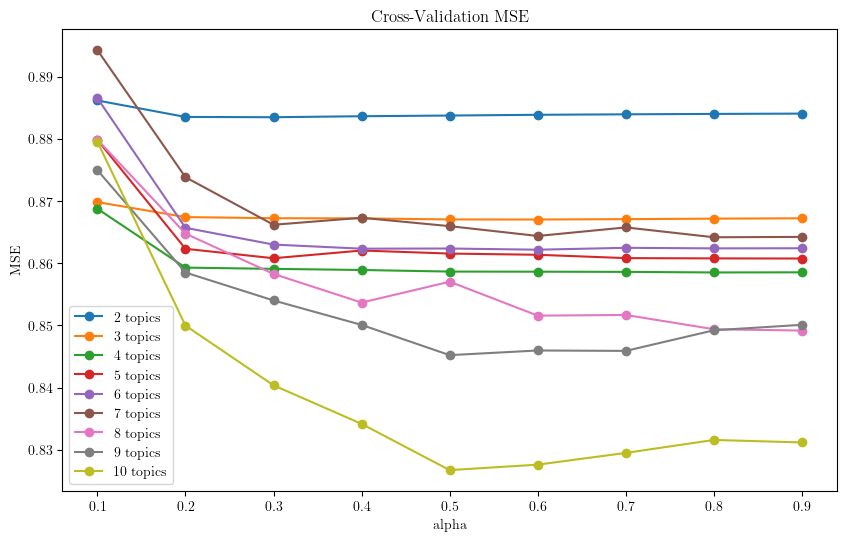

Cross-Validation Summary
Alpha candidate values:  [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Number of topics:  range(2, 11)
Number of folds:  10
CV Random state:  0
Top 1 hyperparam combinations - num_bases: 10.00, alpha: 0.50, MSE: 0.8267
Top 2 hyperparam combinations - num_bases: 10.00, alpha: 0.60, MSE: 0.8276
Top 3 hyperparam combinations - num_bases: 10.00, alpha: 0.70, MSE: 0.8295


In [6]:
model.cv_mse_plot()
model.cv_summary()

## Calculate Benchmarks

In [9]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed

def run_fold(train, test, X, Y, random_state):
    """
    Function to train and evaluate models on a single fold.

    Parameters:
        train (array-like): Indices for training data.
        test (array-like): Indices for testing data.
        X (array-like): Feature matrix.
        Y (array-like): Response vector.
        random_state (int): Seed for reproducibility.

    Returns:
        dict: MSE scores for Lasso, Gradient Boosting Regressor, and Random Forest Regressor.
    """
    results = {}

    # Lasso Regression
    lasso_reg = Lasso(alpha=1, random_state=random_state).fit(X[train], Y[train])
    lasso_pred = lasso_reg.predict(X[test])
    results['Lasso'] = mean_squared_error(Y[test], lasso_pred)

    # Gradient Boosting Regressor
    gbr_reg = GradientBoostingRegressor(random_state=random_state).fit(X[train], Y[train])
    gbr_pred = gbr_reg.predict(X[test])
    results['GradientBoostReg'] = mean_squared_error(Y[test], gbr_pred)

    # Random Forest Regressor
    rf_reg = RandomForestRegressor(random_state=random_state).fit(X[train], Y[train])
    rf_pred = rf_reg.predict(X[test])
    results['RandomForestReg'] = mean_squared_error(Y[test], rf_pred)

    return results

def parallel_crossval(cv_folds=10, X=None, Y=None, random_state=0, export_dir=None, export_name=None, n_jobs=-1):
    """
    Parallelized function to perform cross-validation benchmarks with specified regression models.

    Parameters:
        cv_folds (int): Number of cross-validation folds.
        X (array-like): Feature matrix.
        Y (array-like): Response vector.
        random_state (int): Seed for reproducibility.
        export_dir (str): Directory to save results.
        export_name (str): Filename to save results.
        n_jobs (int): Number of parallel jobs (default -1 uses all available cores).

    Returns:
        mse_scores (DataFrame): DataFrame with MSE scores for each model and fold.
    """
    if X is None or X.size == 0:
        raise ValueError('No feature matrix provided.')
    if Y is None or Y.size == 0:
        raise ValueError('No response vector provided.')

    # Initialize KFold object
    kf = KFold(n_splits=cv_folds, random_state=random_state, shuffle=True)
    kfolds = list(kf.split(X))

    # Parallel execution across folds
    results = Parallel(n_jobs=n_jobs)(
        delayed(run_fold)(train, test, X, Y, random_state) for train, test in kfolds
    )

    # Create DataFrame from results
    mse_scores = pd.DataFrame(results)

    # Export results to CSV if specified
    if export_dir and export_name:
        mse_scores.to_csv(export_dir + export_name, index=False)

    return mse_scores

# Example usage
cv_folds = 10
random_state = 0
mse_results = parallel_crossval(
    cv_folds=cv_folds,
    X=X_norm_scaled,
    Y=Y_norm,
    random_state=random_state,
    n_jobs=10  # Use all available cores
)


In [11]:
mse_results.mean()

Lasso               1.003139
GradientBoostReg    0.831721
RandomForestReg     0.822102
dtype: float64

In [12]:
model.cv_errors

array([[[0.90536593, 0.74270133, 0.85319702, 0.91245754, 0.75870202,
         0.88040654, 1.31702568, 0.68054854, 0.96161823, 0.84981818],
        [0.89316984, 0.73475029, 0.84921918, 0.90525014, 0.76309255,
         0.88256417, 1.31739727, 0.69041819, 0.96228919, 0.83723185],
        [0.88999165, 0.73272749, 0.84864925, 0.90377724, 0.76514761,
         0.88428327, 1.31872636, 0.69424152, 0.96332827, 0.83404327],
        [0.88852813, 0.73199235, 0.84848742, 0.90330227, 0.7661561 ,
         0.8853503 , 1.31970664, 0.69614173, 0.96415687, 0.83271086],
        [0.88776405, 0.73160227, 0.84837301, 0.90306294, 0.76675264,
         0.88595852, 1.320269  , 0.69736677, 0.96453439, 0.83194018],
        [0.88730067, 0.73135224, 0.84832771, 0.90293947, 0.76723068,
         0.88637735, 1.32065957, 0.69821791, 0.96495203, 0.83148541],
        [0.88697654, 0.73114001, 0.84830275, 0.90286554, 0.76755624,
         0.88668729, 1.32096473, 0.69878376, 0.96515225, 0.83117028],
        [0.8867381 , 0.7310

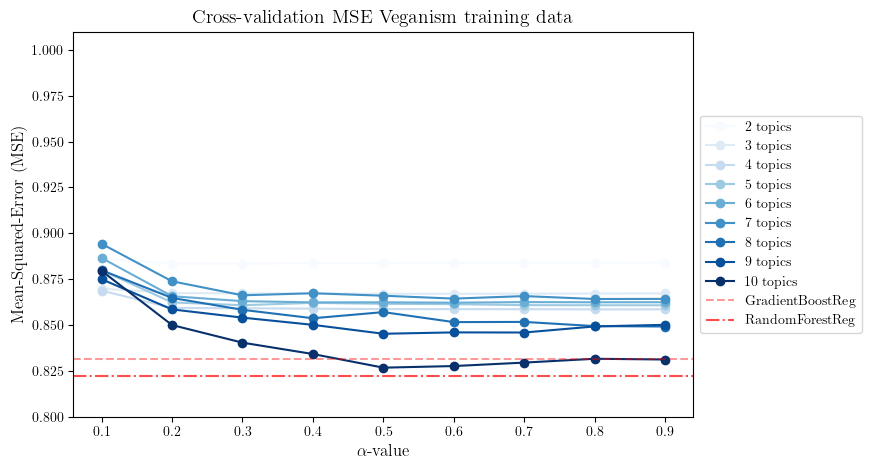

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Import MSE scores from saved CSV files and average of folds per alpha value per number of topics
topic_range = range(2, 11)
niter = 100
alpha_range = np.linspace(0.1, 0.9, 9)

# Create one plot that combines all of them in different colors
random_state = 0


fig, ax = plt.subplots(1, 1, figsize=(8, 5))  # Adjust figure size as needed

mse_scores_bm = mse_results.mean(axis=0)
mse_scores = np.mean(model.cv_errors, axis=2)


colors = plt.cm.Blues(np.linspace(0, 1, len(topic_range)))
for i, num_bases in enumerate(model.cv_num_base_range):
    ax.plot(
        alpha_range,
        mse_scores[i],
        label=f"{num_bases} topics",
        marker="o",
        color = colors[i],
            )

# Add straight lines at the benchmark values in mse_scores_bm in red 
line_styles = ['-', '--', '-.', ':']
for i in range(1, len(mse_scores_bm)):
    ax.axhline(mse_scores_bm[i], color="red", linestyle=line_styles[i], alpha=0.1 + 0.3 * i, label=mse_scores_bm.index[i])

# Plot the MSE scores for each number of topics
ax.set_title(f"Cross-validation MSE Veganism training data", fontsize=14)
ax.set_xlabel(r"$\alpha$-value", fontsize=12)
ax.set_ylim(0.8,1.01)
ax.set_ylabel("Mean-Squared-Error (MSE)", fontsize=12)

# Set less transparent legend
ax.legend(framealpha=.50)
# ax.legend(loc= 'top right')

#legend position right next to graph
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save figure if needed for the paper
# plt.savefig("acl_paper_figure.png", bbox_inches="tight", dpi=300)

plt.show()

# export the plot
# fig.savefig(data_dir / f"Veganism_Args_{y_name}_{topic_range}Topics_{alpha_label}_Training_{emb_name}.png", bbox_inches="tight", dpi=600)
    # fig.savefig(data_dir / f"Veganism_Args_{y_name}_{topic_range}Topics_{alpha_label}_Training_Presentation.png", bbox_inches="tight", dpi=600)


# Explore specific model fits   

In [41]:

from utils.snmf import SNMF
def model_fitting(
        embeddings,
        Y, 
        num_bases = 10,
        random_state = 0,
        alpha = 0.2,
        ninter = 100,
        test_size = 0.2,
        n_sent = 10,
        df = df,
        name = "_preview",
        return_W = False,
        save_model = False,
        return_train = False
): 
    
        X = np.array(embeddings)
        X_norm = (X - np.mean(X, axis=0))/(np.std(X,axis=0))
        Y_norm = (Y - np.mean(Y))/(np.std(Y))
        print(f" X_norm max: {np.max(X_norm):.4f}, min: {np.min(X_norm):.4f}, \
        mean: {np.mean(X_norm):.4f}, sd: {np.std(X_norm):.4f}")

        print(f" Y_norm max: {np.max(Y_norm):.4f}, min: {np.min(Y_norm):.4f},\
        mean: {np.mean(Y_norm):.4f}, sd: {np.std(Y_norm):.4f}")

        # Scale down the high-dimensional embedding to avoid dominance 
        X_norm_scaled = X_norm/(X_norm.shape[1]**0.1)
        print(f" X_norm_scaled max: {np.max(X_norm_scaled):.4f}, min: {np.min(X_norm_scaled):.4f}, \
        mean: {np.mean(X_norm_scaled):.4f}, sd: {np.std(X_norm_scaled):.4f}")

        print(f"{X.shape = }")

        np.random.seed(random_state)
        test = np.random.choice(len(Y), int(len(Y)*test_size), replace=False)
        # sort test_indices
        test = np.sort(test)
        train = np.setdiff1d(range(len(Y)), test)


        X_tilde = np.hstack(((alpha**0.5)*X_norm_scaled, 
                                ((1-alpha)**0.5)*np.array(Y_norm).reshape(-1,1)))

        # Fit SNMF model on training data
        snmf_mdl = SNMF(np.array(X_tilde[train, :]).T, 
                        num_bases=num_bases, 
                        random_state=random_state) 
        snmf_mdl.factorize(niter=ninter)
        W_snmf = snmf_mdl.H.T # Need to ensure that nonnegativity is enforced on the matrix factor with the right dimensionality
        H_snmf = snmf_mdl.W.T

        # print all with 2 decimals
        print(f"Beta estimate: \n {np.round(H_snmf[:,-1], decimals=2)} \n  ")

        print(f"In sample MSE: {np.mean((Y_norm[train] - np.dot(W_snmf, H_snmf[:,-1])*((1-alpha)**(-0.5)))**2):.2f}")
        print(f"In sample 'Accuracy': {sum(np.sign(Y_norm[train]) == np.sign(np.dot(W_snmf, H_snmf[:,-1])*((1-alpha)**(-0.5))))/len(train):.2f}")

        if test_size != 0:
                # Predict responses on k-fold test data (exlcuding Y)
                snmf_mdl.update_h_with_w(newdata=X_tilde[test,0:-1].T,niter=100, show_progress=False, 
                                        compute_h=True, compute_w=False)
                pred_latent = snmf_mdl.H_new.T
                pred_response = np.dot(pred_latent, H_snmf[:,-1])

                print(f"\nTest MSE: {np.mean((pred_response * ((1 - alpha) ** (-0.5)) - Y_norm[test]) ** 2):.2f}")
                print(f"Test 'Accuracy': {sum(np.sign(Y_norm[test]) == np.sign(pred_response))/len(test):.2f}")

        # plot a histogram of the values for each column of H_snmf
        bins = 25
        fig, ax = plt.subplots(1,num_bases, figsize=(5*num_bases,5))
        ax = ax.flatten()

        for i in range(num_bases):
                ax[i].hist(H_snmf[:,i],bins)
                ax[i].set_title(f"Topic {i+1}")

        fig.suptitle(f"Histogram of values in H_snmf")

        fig.savefig(data_dir / f"CMV_pairs_SNMF_beta.png", bbox_inches='tight')

        pred_response_train = np.dot(W_snmf, H_snmf[:,-1])*((1-alpha)**(-0.5))

        print(f"Training set: True responses: max: {np.max(Y_norm):.4f}, min: {np.min(Y_norm):.4f}, ")
        print(f"Training set: True responses: mean: {np.mean(Y_norm):.4f}, sd: {np.std(Y_norm):.4f}")
        print(f"Training set: Predicted responses: max: {np.max(pred_response_train):.4f}, min: {np.min(pred_response_train):.4f}, ")
        print(f"Training set: Predicted responses: mean: {np.mean(pred_response_train):.4f}, sd: {np.std(pred_response_train):.4f}") 

        print(f"Test set: True responses: max: {np.max(Y_norm[test]):.4f}, min: {np.min(Y_norm[test]):.4f}, ")
        print(f"Test set: True responses: mean: {np.mean(Y_norm[test]):.4f}, sd: {np.std(Y_norm[test]):.4f}")
        print(f"Test set: Predicted responses: max: {np.max(pred_response):.4f}, min: {np.min(pred_response):.4f}, ")
        print(f"Test set: Predicted responses: mean: {np.mean(pred_response):.4f}, sd: {np.std(pred_response):.4f}")

        df_other = df[df.Training_set == 1 ]
        df_other = df_other.reset_index(drop=True)
        # only keep train rows of df_other
        df_other = df_other.iloc[train,:]
        df_other = df_other.reset_index(drop=True)

        print(f"{df_other.shape = }, {W_snmf.shape = }")

        pd.set_option('display.max_colwidth', 1)
        import re
        text =  ""
        with open(f'sample_topics{num_bases}_{random_state}RandomState_{alpha}Alpha_{name}_{test_size}testsize.txt', 'w') as f:
                for i in range(0, num_bases):
                        highest_ci = np.argsort(W_snmf[:,i])[-n_sent:]
                        text += f"Samples with highest value in column {i} of W_snmf with associated beta {np.round(H_snmf[i,-1], decimals=2)}:\n"


                        for idx in highest_ci[::-1]:
                                sample_text = df_other['New_Argument'][idx].strip().replace('\n', ' ')
                                sample_label = np.round(Y_norm[idx],decimals= 2)
                                text += f" Label: {sample_label}, {df_other.Origin_and_Prompt[idx][-15:]} || "
                                text += f"Original: {df_other.Original_ID[idx]:03d}, Categorie: {df_other.Categories[idx]:20s}, {df_other.Subcategories[idx]:27s}||"
                                text +=  "Topics: " + " ".join([f"{x:.2f}" for x in W_snmf[idx, :]]) + " ||"
                                text += f" {sample_text}\n"
                        text += "\n"

                        medium_ci = np.argsort(W_snmf[:,i])[int(len(W_snmf[:,i])/2)-int(n_sent/2):int(len(W_snmf[:,i])/2)+int(n_sent/2)]
                        text += f"Samples with medium value in column {i} of W_snmf with associated beta {np.round(H_snmf[i,-1], decimals=2)}:\n"

                        for idx in medium_ci[::-1]:
                                sample_text = df_other['New_Argument'][idx].strip().replace('\n', ' ')
                                # sample_label = np.round(df['thumbs_up_rate'][idx], decimals=2)
                                sample_label = np.round(Y_norm[idx],decimals= 2)
                                text += f" Label: {sample_label} || "
                                text += f"Original: {df_other.Original_ID[idx]:03d}, Categorie: {df_other.Categories[idx]:20s}, {df_other.Subcategories[idx]:27s}||"
                                text +=  "Topics: " + " ".join([f"{x:.2f}" for x in W_snmf[idx, :]]) + " ||"
                                text += f" {sample_text}\n"
                        text += "\n"

                        lowest_ci = np.argsort(W_snmf[:,i])[:n_sent]
                        text += f"Samples with lowest value in column {i} of W_snmf with associated beta {np.round(H_snmf[i,-1], decimals=2)}:\n"

                        for idx in lowest_ci[::-1]:
                                sample_text = df_other['New_Argument'][idx].strip().replace('\n', ' ')
                                # sample_label = np.round(df['forwards_rate'][idx],decimals= 4)
                                sample_label = np.round(Y_norm[idx],decimals= 2)
                                text += f" Label: {sample_label} || "
                                text += f"Original: {df_other.Original_ID[idx]:03d}, Categorie: {df_other.Categories[idx]:20s}, {df_other.Subcategories[idx]:27s}||"
                                text +=  "Topics: " + " ".join([f"{x:.2f}" for x in W_snmf[idx, :]]) + " ||"
                                text += f" {sample_text}\n"
                        text +=  "_____"*100 + "\n\n" 


                text += "_____"*100 + "\n" + "_____"*100 + "\n" + "_____"*100 + "\n"
                highest_ci = np.argsort(W_snmf[:,0] + W_snmf[:,1])[-n_sent:]
                text += f"Samples with highest sum of in column 0 and column 1 of W_snmf:\n"
                for idx in highest_ci[::-1]:
                        sample_text = df_other['New_Argument'][idx].strip().replace('\n', ' ')
                        sample_label = np.round(Y_norm[idx],decimals= 2)
                        text += f" Label: {sample_label} || "
                        text += f"Original: {df_other.Original_ID[idx]:03d}, Categorie: {df_other.Categories[idx]:20s}, {df_other.Subcategories[idx]:27s}||"
                        text +=  "Topics: " + " ".join([f"{x:.2f}" for x in W_snmf[idx, :]]) + " ||"

                        text += f" {sample_text}\n"
                text +=  "\n\n" 

                highest_ci = np.argsort(W_snmf[:,-2] + W_snmf[:,-1])[-n_sent:]
                text += f"Samples with highest sum of in column 8 and column 9 of W_snmf:\n"
                for idx in highest_ci[::-1]:
                        sample_text = df_other['New_Argument'][idx].strip().replace('\n', ' ')
                        sample_label = np.round(Y_norm[idx],decimals= 2)
                        text += f" Label: {sample_label} || "
                        text += f"Original: {df_other.Original_ID[idx]:03d}, Categorie: {df_other.Categories[idx]:20s}, {df_other.Subcategories[idx]:27s}||"
                        text +=  "Topics: " + " ".join([f"{x:.2f}" for x in W_snmf[idx, :]]) + " ||"
                        text += f" {sample_text}\n"


                text = re.sub(' +', ' ', text)
                f.write(text)
        
        if save_model == True: 
                snmf_mdl.save(f"model_topics{num_bases}_{random_state}RandomState_{alpha}Alpha_{name}_{test_size}testsize")


        if return_W == True:
                return W_snmf
        
        if return_train == True:
                return train

 X_norm max: 4.8121, min: -5.1121,         mean: 0.0000, sd: 1.0000
 Y_norm max: 4.6644, min: -2.1372,        mean: -0.0000, sd: 1.0000
 X_norm_scaled max: 2.3104, min: -2.4545,         mean: 0.0000, sd: 0.4801
X.shape = (804, 1536)
Beta estimate: 
 [-0.1   0.67  0.04 -0.24  0.24  0.43 -0.68  0.21 -0.95  0.5 ] 
  
In sample MSE: 0.82
In sample 'Accuracy': 0.68

Test MSE: 0.70
Test 'Accuracy': 0.61
Training set: True responses: max: 4.6644, min: -2.1372, 
Training set: True responses: mean: -0.0000, sd: 1.0000
Training set: Predicted responses: max: 1.0767, min: -1.1764, 
Training set: Predicted responses: mean: 0.0123, sd: 0.4754
Test set: True responses: max: 3.7337, min: -1.9238, 
Test set: True responses: mean: -0.0319, sd: 0.8973
Test set: Predicted responses: max: 0.5621, min: -0.6586, 
Test set: Predicted responses: mean: 0.0253, sd: 0.3038
df_other.shape = (644, 35), W_snmf.shape = (644, 10)


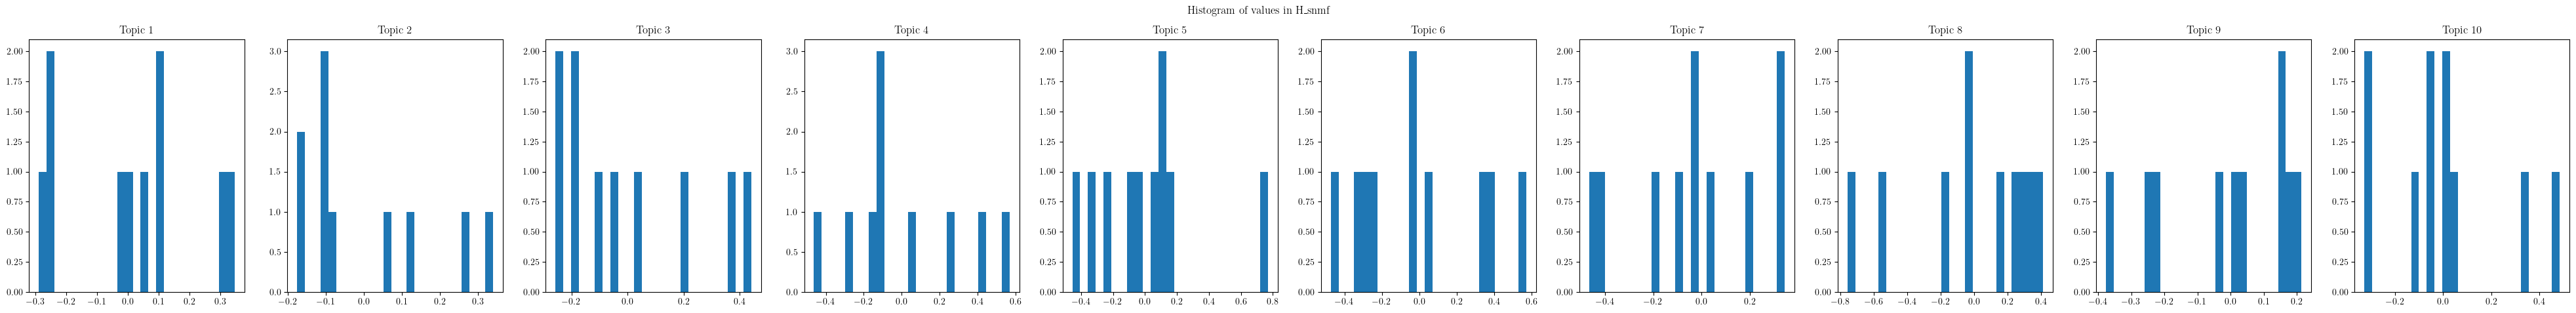

In [42]:
train_idx = model_fitting(
        embeddings = embeddings_train,
        Y = np.array(df.BT_Score[df.Training_set == 1]),
        num_bases = 10,
        random_state = 44,
        alpha = 0.5,
        ninter = 100,
        test_size = 0.2,
        n_sent = 20,
        df = df,
        name = "BT_Score_new_July",
        return_W = False,
        save_model = False,
        return_train = True)

In [43]:
model_fit_idx = np.zeros(sum(df.Training_set == 1))
model_fit_idx[train_idx] = 1
df["model_fit_idx"] = 0
df["model_fit_idx"][df.Training_set == 1] = model_fit_idx
df[df.model_fit_idx == 1]

embeddings_model_fit = embeddings_train[train_idx,:]

/var/folders/1n/l1qs9bwj2h9c06x52w17rfdm0000gp/T/ipykernel_78167/688493184.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["model_fit_idx"][df.Training_set == 1] = model_fit_idx


In [74]:
## recreate the in sample topic loadings 
test_size = 0.2

np.random.seed(random_state)
test = np.random.choice(len(Y_norm), int(len(Y_norm)*test_size), replace=False)
# sort test_indices
test = np.sort(test)
train = np.setdiff1d(range(len(Y_norm)), test)


# import a topic model from 
num_bases = 10
random_state = 44
alpha = 0.5

snmf_mdl = SNMF(np.array(X_norm[:]).T, 
                        num_bases=num_bases, 
                        random_state=random_state) 
snmf_mdl.load(f"model_topics10_{random_state}RandomState_0.5Alpha_BT_Score_0.2testsize.npz")

H_snmf = snmf_mdl.W.T
W_snmf = snmf_mdl.H.T

#  standardize the model to the original scale
# get variance estimate for each column of W 
S = np.diag(np.std(W_snmf, axis=0))
W_norm = W_snmf @ np.linalg.inv(S)

# # # plot histogram for each column of W_norm
# # fig, ax = plt.subplots(1, num_bases, figsize=(20, 5))
# # for i in range(num_bases):
# #     ax[i].hist(W_norm[:,i], bins=50)
# #     ax[i].set_title(f"Component {i+1}")

H_norm = S @ H_snmf

W_norm.shape, len(train)

df_W_og = pd.DataFrame(None, columns = [f"topic_{i+1}_og" for i in range(num_bases)], index = range(sum(df.Training_set == 1)))
for i in range(num_bases):
        df_W_og[f"topic_{i+1}_og"][train] = W_norm[:,i]
        # df_W_og[f"topic_{i+1}_og"][train] = W_snmf[:,i]

# create 10 new columns in df called topic_1_og, topic_2_og, ... topic_10_og
for i in range(num_bases):
        df[f"topic_{i+1}_og"] = None
for i in range(num_bases):
        df[f"topic_{i+1}_og"][df.Training_set ==1] = np.array(df_W_og[f"topic_{i+1}_og"])



# Infer topic loadings on all documents 
Y = df.BT_Score
Y = Y.to_numpy()
X = np.array(embeddings)
print(f" X max: {np.max(X):.4f}, min: {np.min(X):.4f}, mean: {np.mean(X):.4f}, sd: {np.std(X):.4f}")
print(f" Y max: {np.max(Y):.4f}, min: {np.min(Y):.4f} mean: {np.mean(Y):.4f}, sd: {np.std(Y):.4f}")

# X_norm = (X - np.mean(X, axis=0))/(np.std(X,axis=0)+10**(-10))
X_norm = (X - np.mean(X, axis=0))/(np.std(X,axis=0))
Y_norm = (Y - np.mean(Y))/(np.std(Y))
print(f" X_norm max: {np.max(X_norm):.4f}, min: {np.min(X_norm):.4f}, \
mean: {np.mean(X_norm):.4f}, sd: {np.std(X_norm):.4f}")

print(f" Y_norm max: {np.max(Y_norm):.4f}, min: {np.min(Y_norm):.4f},\
 mean: {np.mean(Y_norm):.4f}, sd: {np.std(Y_norm):.4f}")

# Scale down the high-dimensional embedding to avoid dominance 
X_norm_scaled = X_norm/(X_norm.shape[1]**0.1)
print(f" X_norm_scaled max: {np.max(X_norm_scaled):.4f}, min: {np.min(X_norm_scaled):.4f}, \
mean: {np.mean(X_norm_scaled):.4f}, sd: {np.std(X_norm_scaled):.4f}")

print(f'{X.shape =}, Y.shape = {Y.shape}')

# create 10 new columns in df called topic_1_og, topic_2_og, ... topic_10_og
for i in range(num_bases):
        df[f"topic_{i+1}_inf"] = None

num_bases = 10
random_state = 44
alpha = 0.5

snmf_mdl = SNMF(np.array(X_norm[:]).T, 
                        num_bases=num_bases, 
                        random_state=random_state) 
snmf_mdl.load(f"model_topics10_{random_state}RandomState_0.5Alpha_BT_Score_0.2testsize.npz")

H_snmf = snmf_mdl.W.T
W_snmf = snmf_mdl.H.T

#  standardize the model to the original scale
# get variance estimate for each column of W 
S = np.diag(np.std(W_snmf, axis=0))
W_norm = W_snmf @ np.linalg.inv(S)

# # # plot histogram for each column of W_norm
# # fig, ax = plt.subplots(1, num_bases, figsize=(20, 5))
# # for i in range(num_bases):
# #     ax[i].hist(W_norm[:,i], bins=50)
# #     ax[i].set_title(f"Component {i+1}")

H_norm = S @ H_snmf

print(np.max(np.abs(W_snmf @ H_snmf - W_norm @ H_norm))) 
print(np.std(W_norm, axis=0))

snmf_mdl.H = W_norm.T
snmf_mdl.W = H_norm.T

X_tilde = np.hstack(((alpha**0.5)*X_norm_scaled, 
                        ((1-alpha)**0.5)*np.array(Y_norm).reshape(-1,1)))

# Predict responses on k-fold test data (exlcuding Y)
snmf_mdl.update_h_with_w(newdata=X_tilde[:,0:-1].T,niter=100, show_progress=False, 
                        compute_h=True, compute_w=False)
pred_latent = snmf_mdl.H_new.T
pred_latent.shape

for i in range(num_bases):
        df[f"topic_{i+1}_inf"] = pred_latent[:,i]

# df.to_csv(data_dir / "Generated_Veganism_Arguments_with_Scores_and_Topics.csv", index=False)

/var/folders/1n/l1qs9bwj2h9c06x52w17rfdm0000gp/T/ipykernel_53783/2961519588.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"topic_{i+1}_og"][df.Training_set ==1] = np.array(df_W_og[f"topic_{i+1}_og"])
/var/folders/1n/l1qs9bwj2h9c06x52w17rfdm0000gp/T/ipykernel_53783/2961519588.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"topic_{i+1}_og"][df.Training_set ==1] = np.array(df_W_og[f"topic_{i+1}_og"])
/var/folders/1n/l1qs9bwj2h9c06x52w17rfdm0000gp/T/ipykernel_53783/2961519588.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

 X max: 0.2387, min: -0.6837, mean: -0.0007, sd: 0.0255
 Y max: 2.2558, min: 0.4706 mean: 1.0249, sd: 0.2344
 X_norm max: 4.8250, min: -5.1675, mean: -0.0000, sd: 1.0000
 Y_norm max: 5.2515, min: -2.3648, mean: -0.0000, sd: 1.0000
 X_norm_scaled max: 2.3166, min: -2.4811, mean: -0.0000, sd: 0.4801
X.shape =(1309, 1536), Y.shape = (1309,)
3.3306690738754696e-16
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Causal inference

In [44]:
df = pd.read_csv(data_dir / "Generated_Veganism_Arguments_with_Scores_and_Topics.csv")

In [45]:
df.columns

Index(['Original', 'Summary', 'New_Argument', 'New_Argument_Raw',
       'Origin_and_Prompt', 'Length', 'Training_set', 'Summary_ID',
       'Original_ID', 'Categories', 'Subcategories', 'Net_Wins', 'BT_Score',
       'BT_Score_01', 'model_fit_idx', 'topic_1_og', 'topic_2_og',
       'topic_3_og', 'topic_4_og', 'topic_5_og', 'topic_6_og', 'topic_7_og',
       'topic_8_og', 'topic_9_og', 'topic_10_og', 'topic_1_inf', 'topic_2_inf',
       'topic_3_inf', 'topic_4_inf', 'topic_5_inf', 'topic_6_inf',
       'topic_7_inf', 'topic_8_inf', 'topic_9_inf', 'topic_10_inf'],
      dtype='object')

In [46]:
## standardize with the originial varianze and mean
Y_train = np.array(df.BT_Score[df.model_fit_idx == 1])
X_train = np.array(embeddings_model_fit)

Y_test_causal = np.array(df.BT_Score[df.Training_set == 0]) ## match previous edit to shift the distribution
X_test_causal = np.array(embeddings_test)
print(f" X max: {np.max(X_test_causal):.4f}, min: {np.min(X_test_causal):.4f}, mean: {np.mean(X_test_causal):.4f}, sd: {np.std(X_test_causal):.4f}")
print(f" Y max: {np.max(Y_test_causal):.4f}, min: {np.min(Y_test_causal):.4f} mean: {np.mean(Y_test_causal):.4f}, sd: {np.std(Y_test_causal):.4f}")

X_norm = (X_test_causal - np.mean(X_train, axis=0))/(np.std(X_train,axis=0))
Y_norm = (Y_test_causal - np.mean(Y_train))/(np.std(Y_train))
print(f" X_norm max: {np.max(X_norm):.4f}, min: {np.min(X_norm):.4f}, \
mean: {np.mean(X_norm):.4f}, sd: {np.std(X_norm):.4f}")

print(f" Y_norm max: {np.max(Y_norm):.4f}, min: {np.min(Y_norm):.4f},\
 mean: {np.mean(Y_norm):.4f}, sd: {np.std(Y_norm):.4f}")

# Scale down the high-dimensional embedding to avoid dominance 
X_norm_scaled = X_norm /(X_norm.shape[1]**0.1)
print(f" X_norm_scaled max: {np.max(X_norm_scaled):.4f}, min: {np.min(X_norm_scaled):.4f}, \
mean: {np.mean(X_norm_scaled):.4f}, sd: {np.std(X_norm_scaled):.4f}")

print(f'{X_test_causal.shape =}')
print(f'{X_norm_scaled.shape =}')

 X max: 0.2348, min: -0.6810, mean: -0.0007, sd: 0.0255
 Y max: 1.6223, min: 0.5484 mean: 1.0143, sd: 0.1804
 X_norm max: 4.8452, min: -5.1661, mean: 0.0001, sd: 0.9952
 Y_norm max: 2.1909, min: -1.8057, mean: -0.0719, sd: 0.6714
 X_norm_scaled max: 2.3264, min: -2.4804, mean: 0.0001, sd: 0.4778
X_test_causal.shape =(505, 1536)
X_norm_scaled.shape =(505, 1536)


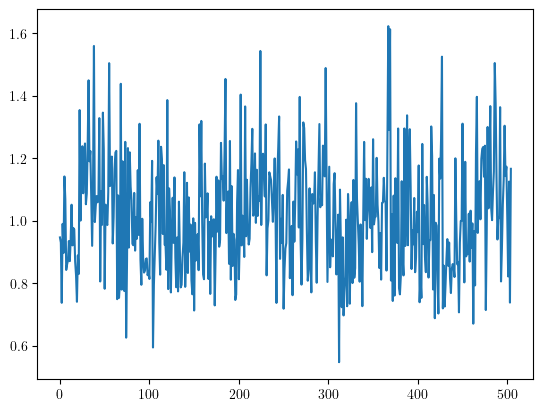

In [76]:
plt.plot(Y_test_causal)

In [48]:
# import a topic model from 
num_bases = 10
random_state = 44
alpha = 0.5

snmf_mdl = SNMF(np.array(X_norm[:]).T, 
                        num_bases=num_bases, 
                        random_state=random_state) 
snmf_mdl.load(f"model_topics10_{random_state}RandomState_0.5Alpha_BT_Score_0.2testsize.npz")

H_snmf = snmf_mdl.W.T
W_snmf = snmf_mdl.H.T

#  standardize the model to the original scale
# get variance estimate for each column of W 
S = np.diag(np.std(W_snmf, axis=0))
W_norm = W_snmf @ np.linalg.inv(S)

# # # plot histogram for each column of W_norm
# # fig, ax = plt.subplots(1, num_bases, figsize=(20, 5))
# # for i in range(num_bases):
# #     ax[i].hist(W_norm[:,i], bins=50)
# #     ax[i].set_title(f"Component {i+1}")

H_norm = S @ H_snmf

print(np.max(np.abs(W_snmf @ H_snmf - W_norm @ H_norm))) 
print(np.std(W_norm, axis=0))

snmf_mdl.H = W_norm.T
snmf_mdl.W = H_norm.T

X_tilde = np.hstack(((alpha**0.5)*X_norm_scaled, 
                        ((1-alpha)**0.5)*np.array(Y_norm).reshape(-1,1)))

# Predict responses on k-fold test data (exlcuding Y)
snmf_mdl.update_h_with_w(newdata=X_tilde[:,0:-1].T,niter=100, show_progress=False, 
                        compute_h=True, compute_w=False)
pred_latent = snmf_mdl.H_new.T

pred_response = np.dot(pred_latent, H_norm[:,-1])
print(f"Test MSE: {np.mean((pred_response * ((1 - alpha) ** (-0.5)) - Y_norm) ** 2):.2f}")

3.3306690738754696e-16
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test MSE: 0.44


In [70]:
df.Length[df.Training_set == 0].values

array([263, 252, 260, 261, 268, 252, 245, 266, 266, 253, 265, 255, 242,
       271, 267, 277, 273, 276, 260, 270, 327, 320, 278, 298, 281, 317,
       255, 267, 276, 302, 262, 252, 274, 310, 349, 365, 279, 314, 293,
       296, 281, 283, 311, 264, 322, 277, 219, 256, 295, 268, 224, 252,
       294, 261, 270, 380, 264, 225, 263, 275, 257, 272, 272, 285, 234,
       274, 265, 281, 370, 274, 275, 305, 278, 306, 261, 260, 338, 320,
       280, 284, 269, 277, 334, 284, 337, 278, 286, 290, 256, 258, 288,
       263, 275, 319, 303, 268, 243, 273, 257, 269, 273, 267, 317, 266,
       256, 277, 253, 309, 323, 260, 275, 289, 277, 287, 286, 271, 269,
       275, 269, 270, 296, 272, 243, 254, 277, 269, 265, 285, 272, 277,
       276, 266, 284, 277, 254, 273, 270, 265, 263, 273, 266, 268, 267,
       252, 252, 255, 317, 277, 270, 253, 286, 282, 266, 276, 274, 299,
       260, 255, 275, 267, 272, 323, 258, 272, 256, 264, 275, 271, 245,
       242, 277, 299, 273, 291, 283, 276, 286, 332, 292, 261, 31

In [80]:
import statsmodels.api as sm
# run OLS regression of pred_latent on Y_norm
# run OLS regression of pred_latent on Y_norm
X = sm.add_constant(np.array(df_pred_latent))  # Add a constant term to the predictor variable
model = sm.OLS(Y_norm, X)
results = model.fit()

# Generate LaTeX output table without confidence intervals
latex_table = results.summary(slim=True).as_latex()

# Print the LaTeX table
print(latex_table)

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &       y       & \textbf{  R-squared:         } &     0.259   \\
\textbf{Model:}            &      OLS      & \textbf{  Adj. R-squared:    } &     0.242   \\
\textbf{No. Observations:} &        505    & \textbf{  F-statistic:       } &     15.67   \\
\textbf{Covariance Type:}  &   nonrobust   & \textbf{  Prob (F-statistic):} &  2.28e-26   \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
               & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const} &      -1.4419  &        0.230     &    -6.268  &         0.000        &       -1.894    &       -0.990     \\
\textbf{x1}    &      -0.0162  &        0.028     &    -0.579  &         0.563        &       -0.071    &        0.039     \\
\textbf{x2}    &       0.1329  &        0.028     &     4.774  &         0.000        &        0.078    &        0.188     \\
\textbf{x3}    &   

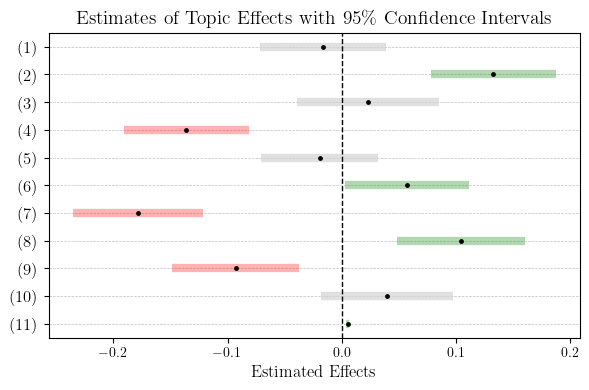

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

# Set font to Computer Modern
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rcParams['text.usetex'] = True

# Extract parameters and confidence intervals from the regression results
params = results.params[1:]
conf_int = results.conf_int()[1:]

# Plot the parameters
fig, ax = plt.subplots(figsize=(6, 4))

for i, (param, (lower, upper)) in enumerate(zip(params, conf_int)):
    # Add horizontal lines between rows
    ax.axhline(i, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

    if lower <= 0 & 0<= upper:
        ax.plot([lower, upper], [i, i], color='lightgray', linewidth=6, solid_capstyle='butt', alpha=0.7)
        ax.scatter(param, i, marker='o', s=6, color='black', zorder=10)

    elif lower <= 0 & 0 >= upper:
        ax.plot([lower, upper], [i, i], color='red', linewidth=6, solid_capstyle='butt', alpha=0.3)
        ax.scatter(param, i, marker='o', s=6, color='black', zorder=10)
    
    else: 
        ax.plot([lower, upper], [i, i], color='green', linewidth=6, solid_capstyle='butt', alpha=0.3)
        ax.scatter(param, i, marker='o', s=6, color='black', zorder=10)

# Customize the plot
ax.axvline(0, color='black', linestyle='--', linewidth=1)  # Add a vertical line at x=0
ax.yaxis.tick_left()
ax.invert_yaxis()  # Flip the graph
ax.set_yticks(np.arange(len(params)))
ax.set_yticklabels( [f"({i+1})" for i in range(len(results.params)-1)], fontsize=12)
ax.set_xlabel('Estimated Effects', fontsize=12)
# include lin break in the title
ax.set_title('Estimates of Topic Effects with 95\% Confidence Intervals', fontsize=14)


# Save or show the plot
plt.tight_layout()
plt.savefig( str(data_dir) + '/Veganism_Causal_Effects_plot_Length.png',bbox_inches="tight", dpi=600)  # Save the plot as an image file
plt.show()


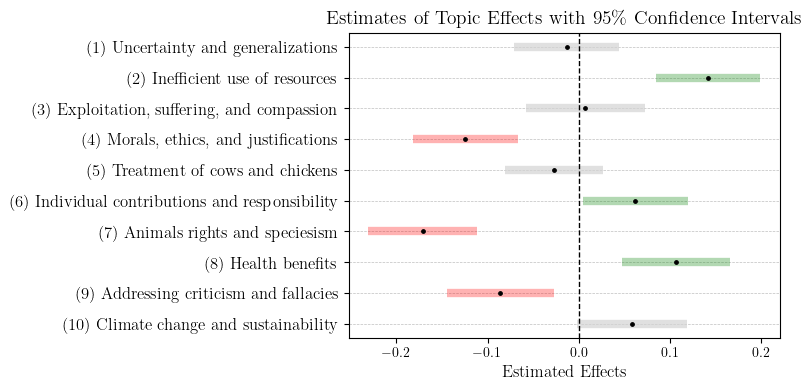

In [80]:
y_labels = [
    "(1) Uncertainty and generalizations ",
    "(2) Inefficient use of resources ",
    "(3) Exploitation, suffering, and compassion",
    "(4) Morals, ethics, and justifications",
    "(5) Treatment of cows and chickens ",
    "(6) Individual contributions and responsibility ",
    "(7) Animals rights and speciesism ",
    "(8) Health benefits ",
    "(9) Addressing criticism and fallacies ",
    "(10) Climate change and sustainability ",
            ]
# Set font to Computer Modern
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rcParams['text.usetex'] = True

# Extract parameters and confidence intervals from the regression results
params = results.params[1:]
conf_int = results.conf_int()[1:]

# Plot the parameters
fig, ax = plt.subplots(figsize=(8, 4))

for i, (param, (lower, upper)) in enumerate(zip(params, conf_int)):
    # Add horizontal lines between rows
    ax.axhline(i, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

    if lower <= 0 & 0<= upper:
        ax.plot([lower, upper], [i, i], color='lightgray', linewidth=6, solid_capstyle='butt', alpha=0.7)
        ax.scatter(param, i, marker='o', s=6, color='black', zorder=10)

    elif lower <= 0 & 0 >= upper:
        ax.plot([lower, upper], [i, i], color='red', linewidth=6, solid_capstyle='butt', alpha=0.3)
        ax.scatter(param, i, marker='o', s=6, color='black', zorder=10)
    
    else: 
        ax.plot([lower, upper], [i, i], color='green', linewidth=6, solid_capstyle='butt', alpha=0.3)
        ax.scatter(param, i, marker='o', s=6, color='black', zorder=10)

# Customize the plot
ax.axvline(0, color='black', linestyle='--', linewidth=1)  # Add a vertical line at x=0
ax.yaxis.tick_left()
ax.invert_yaxis()  # Flip the graph
ax.set_yticks(np.arange(len(params)))
ax.set_yticklabels( y_labels, fontsize=12)
ax.set_xlabel('Estimated Effects', fontsize=12)
# include lin break in the title
ax.set_title('Estimates of Topic Effects with 95\% Confidence Intervals', fontsize=14)


# Save or show the plot
plt.tight_layout()
plt.savefig( str(data_dir) + '/Veganism_Causal_Effects_plot_presentation.png',bbox_inches="tight", dpi=600)  # Save the plot as an image file
plt.show()


# Export the topic loadings for arg optimization

In [65]:
## recreate the in sample topic loadings 
random_state = 44

# import a topic model from 
num_bases = 10
random_state = 44
alpha = 0.5

snmf_mdl = SNMF(np.array(X_norm[:]).T, 
                        num_bases=num_bases, 
                        random_state=random_state) 
snmf_mdl.load(f"model_topics10_{random_state}RandomState_0.5Alpha_BT_Score_0.2testsize.npz")

H_snmf = snmf_mdl.W.T
W_snmf = snmf_mdl.H.T

#  standardize the model to the original scale
# get variance estimate for each column of W 
S = np.diag(np.std(W_snmf, axis=0))
W_norm = W_snmf @ np.linalg.inv(S)
H_norm = S @ H_snmf


# create 10 new columns in df called topic_1_og, topic_2_og, ... topic_10_og
for i in range(num_bases):
        df[f"topic_{i+1}_og"] = None
for i in range(num_bases):
        df[f"topic_{i+1}_og"][df.model_fit_idx ==1] = W_norm[:,i]

/var/folders/1n/l1qs9bwj2h9c06x52w17rfdm0000gp/T/ipykernel_97786/1516786572.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"topic_{i+1}_og"][df.model_fit_idx ==1] = W_norm[:,i]
/var/folders/1n/l1qs9bwj2h9c06x52w17rfdm0000gp/T/ipykernel_97786/1516786572.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"topic_{i+1}_og"][df.model_fit_idx ==1] = W_norm[:,i]
/var/folders/1n/l1qs9bwj2h9c06x52w17rfdm0000gp/T/ipykernel_97786/1516786572.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [75]:
## standardize with the originial varianze and mean
Y_train = np.array(df.BT_Score[df.model_fit_idx == 1])
X_train = np.array(embeddings_model_fit)

Y_test_causal = np.array(df.BT_Score) ## match previous edit to shift the distribution
X_test_causal = np.array(embeddings)
print(f" X max: {np.max(X_test_causal):.4f}, min: {np.min(X_test_causal):.4f}, mean: {np.mean(X_test_causal):.4f}, sd: {np.std(X_test_causal):.4f}")
print(f" Y max: {np.max(Y_test_causal):.4f}, min: {np.min(Y_test_causal):.4f} mean: {np.mean(Y_test_causal):.4f}, sd: {np.std(Y_test_causal):.4f}")

X_norm = (X_test_causal - np.mean(X_train, axis=0))/(np.std(X_train,axis=0))
Y_norm = (Y_test_causal - np.mean(Y_train))/(np.std(Y_train))
print(f" X_norm max: {np.max(X_norm):.4f}, min: {np.min(X_norm):.4f}, \
mean: {np.mean(X_norm):.4f}, sd: {np.std(X_norm):.4f}")

print(f" Y_norm max: {np.max(Y_norm):.4f}, min: {np.min(Y_norm):.4f},\
 mean: {np.mean(Y_norm):.4f}, sd: {np.std(Y_norm):.4f}")

# Scale down the high-dimensional embedding to avoid dominance 
X_norm_scaled = X_norm /(X_norm.shape[1]**0.1)
print(f" X_norm_scaled max: {np.max(X_norm_scaled):.4f}, min: {np.min(X_norm_scaled):.4f}, \
mean: {np.mean(X_norm_scaled):.4f}, sd: {np.std(X_norm_scaled):.4f}")

print(f'{X_test_causal.shape =}')
print(f'{X_norm_scaled.shape =}')

# create 10 new columns in df called topic_1_og, topic_2_og, ... topic_10_og
for i in range(num_bases):
        df[f"topic_{i+1}_inf"] = None

num_bases = 10
random_state = 44
alpha = 0.5

snmf_mdl = SNMF(np.array(X_norm[:]).T, 
                        num_bases=num_bases, 
                        random_state=random_state) 
snmf_mdl.load(f"model_topics10_{random_state}RandomState_0.5Alpha_BT_Score_0.2testsize.npz")

H_snmf = snmf_mdl.W.T
W_snmf = snmf_mdl.H.T

#  standardize the model to the original scale
# get variance estimate for each column of W 
S = np.diag(np.std(W_snmf, axis=0))
W_norm = W_snmf @ np.linalg.inv(S)

# # # plot histogram for each column of W_norm
# # fig, ax = plt.subplots(1, num_bases, figsize=(20, 5))
# # for i in range(num_bases):
# #     ax[i].hist(W_norm[:,i], bins=50)
# #     ax[i].set_title(f"Component {i+1}")

H_norm = S @ H_snmf

print(np.max(np.abs(W_snmf @ H_snmf - W_norm @ H_norm))) 
print(np.std(W_norm, axis=0))

snmf_mdl.H = W_norm.T
snmf_mdl.W = H_norm.T

X_tilde = np.hstack(((alpha**0.5)*X_norm_scaled, 
                        ((1-alpha)**0.5)*np.array(Y_norm).reshape(-1,1)))

# Predict responses on k-fold test data (exlcuding Y)
snmf_mdl.update_h_with_w(newdata=X_tilde[:,0:-1].T,niter=100, show_progress=False, 
                        compute_h=True, compute_w=False)
pred_latent = snmf_mdl.H_new.T
pred_latent.shape

for i in range(num_bases):
        df[f"topic_{i+1}_inf"] = pred_latent[:,i]

df.to_csv(data_dir / "Generated_Veganism_Arguments_with_Scores_and_Topics_new.csv", index=False)

 X max: 0.2387, min: -0.6837, mean: -0.0007, sd: 0.0255
 Y max: 2.2558, min: 0.4706 mean: 1.0249, sd: 0.2344
 X_norm max: 4.9685, min: -5.1661, mean: 0.0001, sd: 0.9981
 Y_norm max: 4.5484, min: -2.0953, mean: -0.0325, sd: 0.8723
 X_norm_scaled max: 2.3856, min: -2.4804, mean: 0.0000, sd: 0.4792
X_test_causal.shape =(1309, 1536)
X_norm_scaled.shape =(1309, 1536)
3.3306690738754696e-16
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Validation experiment

Import new resutls of synthetic arguments to see how they perform against the top 45 arguments of the original collection

In [21]:
# import original argument data
df_experiment = pd.read_excel(data_dir / "Validation_Experiment/validation_experiment_arguments.xlsx", index_col=0).iloc[:, 2:]
df_experiment = df_experiment.reset_index(drop=True)


# import survey results 
df_experiment_results = pd.read_excel(data_dir / "Validation_Experiment/Veganism_validation_experiment_results_vClean.xlsx").iloc[1:,:]
df_experiment_results = df_experiment_results.reset_index(drop=True)

df_experiment_results['usedIndices'] = df_experiment_results.__js_usedIndices.str.split("|")
# deleted two arguments that failed attention tests and seemed odd
df_experiment_results['arg_selected1'] = (df_experiment_results.__js_comparisonTextSelected01 == df_experiment_results.__js_comparisonText01B)*1
df_experiment_results['arg_selected2'] = (df_experiment_results.__js_comparisonTextSelected02 == df_experiment_results.__js_comparisonText02B)*1
df_experiment_results['arg_selected3'] = (df_experiment_results.__js_comparisonTextSelected03 == df_experiment_results.__js_comparisonText03B)*1
df_experiment_results['arg_selected4'] = (df_experiment_results.__js_comparisonTextSelected04 == df_experiment_results.__js_comparisonText04B)*1
df_experiment_results['arg_selected5'] = (df_experiment_results.__js_comparisonTextSelected05 == df_experiment_results.__js_comparisonText05B)*1

print(df_experiment_results.shape)
df_experiment_results.head()

(198, 83)


,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,__js_comparisonText04A,__js_comparisonText04B,__js_comparisonText05A,__js_comparisonText05B,usedIndices,arg_selected1,arg_selected2,arg_selected3,arg_selected4,arg_selected5
0,2024-03-13 08:19:52,2024-03-13 08:29:14,IP Address,*******,100,561,True,2024-03-13 08:29:14.989000,R_1rD81Z51MN3cFPd,*******,...,The meat industry emits more greenhouse gases ...,Industrial animal farming produces three times...,Meat production squanders 70% of grains and 20...,Adopting veganism is a powerful step towards a...,"[94, 1, 11, 63, 4, 90, 23, 59, 2, 54]",1,1,1,1,0
1,2024-03-13 08:19:54,2024-03-13 08:26:49,IP Address,*******,100,414,True,2024-03-13 08:26:49.890000,R_26ypZ06I4BIADIZ,*******,...,It's a general consensus that unnecessary anim...,Adopting veganism is a powerful step towards a...,Veganism combats global warming and resource w...,"By reducing our meat consumption, we're lessen...","[43, 70, 69, 41, 8, 3, 67, 54, 18, 94]",1,0,0,1,0
2,2024-03-13 08:19:57,2024-03-13 08:28:02,IP Address,*******,100,485,True,2024-03-13 08:28:03.042000,R_2Wgv4ekigSHBfz3,*******,...,Animal farming is a significant contributor to...,Switching to a plant-based diet is crucial for...,Adopt a vegan diet to combat global hunger and...,"Producing 1kg of meat requires 2.8kg of crops,...","[95, 12, 86, 29, 14, 68, 90, 30, 8, 69]",1,1,1,1,0
3,2024-03-13 08:19:57,2024-03-13 08:28:50,IP Address,*******,100,533,True,2024-03-13 08:28:51.223000,R_1I2L1BtQKGCMLzH,*******,...,Veganism safeguards our planet by reducing car...,Dairy cows are often slaughtered after only 3-...,Shifting to veganism combats global hunger by ...,Adopt a vegan lifestyle to combat climate chan...,"[32, 92, 4, 39, 71, 18, 48, 76, 34, 5]",1,1,1,0,0
4,2024-03-13 08:19:58,2024-03-13 08:26:05,IP Address,*******,100,367,True,2024-03-13 08:26:06.713000,R_2GycBEvLYsCQA78,*******,...,Adopting a vegan lifestyle can significantly c...,Adopt veganism and fight climate change! This ...,Switching to a plant-based diet is crucial for...,The misuse of antibiotics in livestock breedin...,"[19, 59, 42, 47, 31, 1, 66, 25, 30, 57]",0,1,1,0,1


In [22]:
# Assuming indices is your list
tuples_all_experiment = []
for i in range(df_experiment_results.shape[0]): 
    indices = df_experiment_results.usedIndices[i]

    # Split the list into tuples of two
    tuples = [(indices[i], indices[i+1]) for i in range(0, len(indices), 2)]
    # print(tuples)

    # Iterate over the tuples and df_results simultaneously
    if len(tuples) != 5:
        print("Error: Length of tuples does not match expected length")

    if df_experiment_results.arg_selected1[i] == 1:
        tuples[0] = tuples[0][::-1]
        # print("Switch tuple 1")

    if df_experiment_results.arg_selected2[i] == 1:
        tuples[1] = tuples[1][::-1]
        # print("Switch tuple 2")

    if df_experiment_results.arg_selected3[i] == 1:
        tuples[2] = tuples[2][::-1]
        # print("Switch tuple 3")

    if df_experiment_results.arg_selected4[i] == 1:
        tuples[3] = tuples[3][::-1]
        # print("Switch tuple 4")

    if df_experiment_results.arg_selected5[i] == 1:
        tuples[4] = tuples[4][::-1]
        # print("Switch tuple 5")


    tuples_all_experiment.extend(tuples)

# change format of all elements in tuples_all to int
tuples_all_experiment = [(int(tup[0]), int(tup[1])) for tup in tuples_all_experiment]

In [23]:
df_net_wins_experiment = create_dataframe_net_wins(tuples_all_experiment, n = df_experiment.shape[0])
df_experiment["Net_Wins"] = df_net_wins_experiment["Net_Wins"]

In [24]:
print(df_experiment.groupby("Source").Net_Wins.mean().to_markdown())


| Source                                   |   Net_Wins |
|:-----------------------------------------|-----------:|
| New_GPT_Argument                         |   0.5      |
| New_Synthetic_Argument_Combined          |   1.4      |
| New_Synthetic_Argument_Stronger_Emphasis |   0.733333 |
| Original_Collection                      |  -1.28889  |


In [44]:
# # export tuples_all_experiment to csv
# pd.DataFrame(tuples_all_experiment).to_csv(data_dir / "tuples_all_experiment.csv", index=False)

# # export df_experiment["Source"]
# df_experiment["Source"].to_csv(data_dir / "df_experiment_Source.csv", index=False)

In [25]:
#bootstrapped 
import random

bootstrap_diff_means= []
for _ in range(500):
    bootstrap_sample = random.choices(tuples_all_experiment, k=len(tuples_all_experiment))
    
    df_net_wins_bootstrap = create_dataframe_net_wins(bootstrap_sample, n = df_experiment.shape[0])

    df_experiment["BS_Net_Wins"] = df_net_wins_bootstrap["Net_Wins"]
    
    bootstrap_diff_means.append(df_experiment.groupby("Source").BS_Net_Wins.mean()[0]-df_experiment.groupby("Source").BS_Net_Wins.mean()[1])

lower = np.mean(bootstrap_diff_means) - 1.96*np.std(bootstrap_diff_means-np.mean(bootstrap_diff_means))
upper = np.mean(bootstrap_diff_means) + 1.96*np.std(bootstrap_diff_means-np.mean(bootstrap_diff_means))

print("Bootstrapped Confidence Interval for the difference in Net Wins: \nNew_GPT_Argument - New_Synthetic_Argument_Combined:")
print(f"CI: [{lower:.4f},{upper:.4f}], Mean difference:{np.mean(bootstrap_diff_means):.04f}")

Bootstrapped Confidence Interval for the difference in Net Wins: 
New_GPT_Argument - New_Synthetic_Argument_Combined:
CI: [-4.4564,2.7014], Mean difference:-0.8775


### Futher exploration of results

In [47]:
# df_experiment.to_excel(data_dir/ "Validation_Experiment/Veganism_validation_experiment_results_vClean_withScores.xlsx")

In [188]:
df_results_table = pd.DataFrame(None, columns = np.sort(df_experiment.Source.unique()), index= np.sort(df_experiment.Source.unique()))
df_results_table = df_results_table.fillna(0)

for tup in tuples_all_experiment:
    df_results_table.loc[df_experiment.Source[tup[1]], df_experiment.Source[tup[0]]] += 1

print("Winners on columns, losers on rows")

print(df_results_table.to_markdown())

# change last and first column 
df_results_table = df_results_table[[df_results_table.columns[-1]] + list(df_results_table.columns[1:3])+[df_results_table.columns[0]]]
df_results_table = df_results_table.reindex([df_results_table.index[-1]] + list(df_results_table.index[1:3])+[df_results_table.index[0]])

print(df_results_table.to_markdown())
print(df_results_table.to_latex())


Winners on columns, losers on rows
|                                          |   New_GPT_Argument |   New_Synthetic_Argument_Combined |   New_Synthetic_Argument_Stronger_Emphasis |   Original_Collection |
|:-----------------------------------------|-------------------:|----------------------------------:|-------------------------------------------:|----------------------:|
| New_GPT_Argument                         |                 10 |                                42 |                                         18 |                    54 |
| New_Synthetic_Argument_Combined          |                 37 |                                93 |                                         43 |                   160 |
| New_Synthetic_Argument_Stronger_Emphasis |                 24 |                                54 |                                         37 |                    73 |
| Original_Collection                      |                 58 |                               186 |         

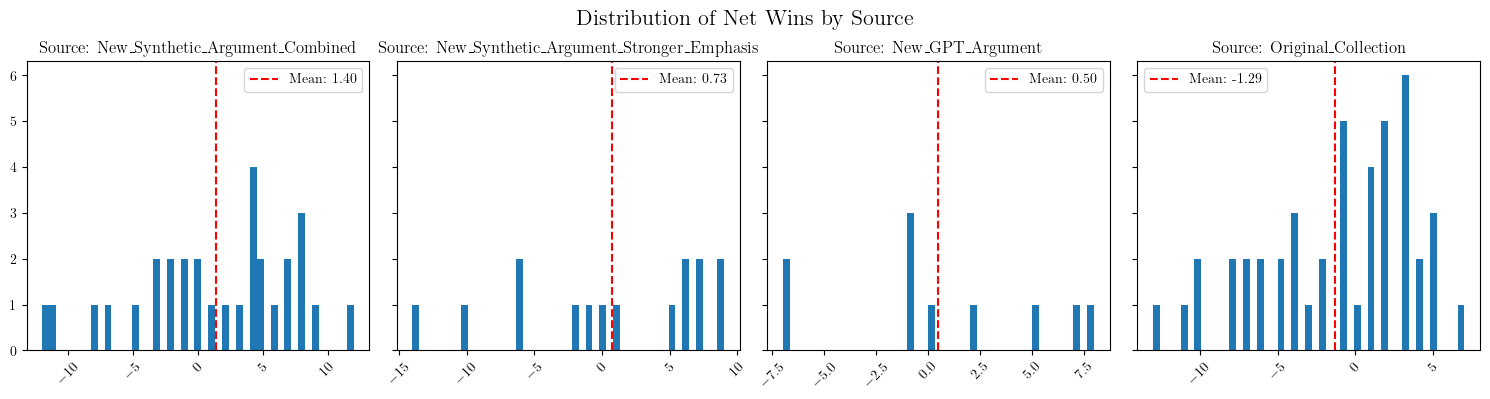

In [27]:
import matplotlib.pyplot as plt

# Assuming df_experiment is your DataFrame and Source is one of its columns
unique_sources = df_experiment['Source'].unique()

fig, axes = plt.subplots(1, len(unique_sources), figsize=(15, 4), sharey=True)

for i, source in enumerate(unique_sources):
    ax = axes[i]
    data = df_experiment[df_experiment['Source'] == source]['Net_Wins']
    
    # Create histogram using plt.hist()
    ax.hist(data, bins=45)
    
    # Calculate mean for the current source
    mean = data.mean()
    
    # Plot vertical line at mean value
    ax.axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f}')
    ax.legend()

    ax.set_title(f'Source: {source}')

    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
# include title for the whole plot
fig.suptitle('Distribution of Net Wins by Source\n \n', fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [28]:
df_experiment["Overall_Winner"] = 0
for i in range(df_experiment_results.shape[0]):
    best = np.where(df_experiment_results['__js_comparisonTextFinal'][i] == df_experiment.synth_text)[0][0]
    df_experiment["Overall_Winner"][best] += 1

df_experiment["Overall_Winner"].mean()

/var/folders/1n/l1qs9bwj2h9c06x52w17rfdm0000gp/T/ipykernel_23531/1229208115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_experiment["Overall_Winner"][best] += 1
/var/folders/1n/l1qs9bwj2h9c06x52w17rfdm0000gp/T/ipykernel_23531/1229208115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_experiment["Overall_Winner"][best] += 1
/var/folders/1n/l1qs9bwj2h9c06x52w17rfdm0000gp/T/ipykernel_23531/1229208115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

1.98

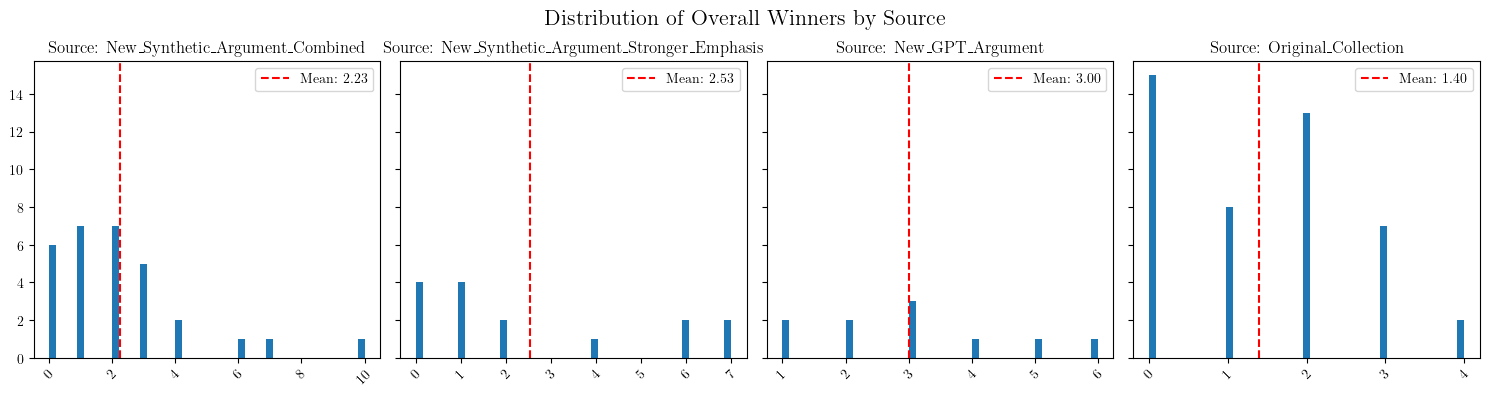

In [29]:
import matplotlib.pyplot as plt

# Assuming df_experiment is your DataFrame and Source is one of its columns
unique_sources = df_experiment['Source'].unique()

fig, axes = plt.subplots(1, len(unique_sources), figsize=(15, 4), sharey=True)

for i, source in enumerate(unique_sources):
    ax = axes[i]
    data = df_experiment[df_experiment['Source'] == source]['Overall_Winner']
    
    # Create histogram using plt.hist()
    ax.hist(data, bins=45)
    
    # Calculate mean for the current source
    mean = data.mean()
    
    # Plot vertical line at mean value
    ax.axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f}')
    ax.legend()

    ax.set_title(f'Source: {source}')

    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)



plt.tight_layout()
# include title for the whole plot
fig.suptitle('Distribution of Overall Winners by Source\n \n', fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()


#### Explore heterogeneity -> only focus on topics 2 and 8

In [30]:
df_experiment.groupby("topic1").Net_Wins.mean() 

topic1
2.0     4.000000
6.0    -9.333333
8.0     5.375000
10.0   -1.764706
Name: Net_Wins, dtype: float64

In [31]:
df_experiment_268 = df_experiment
# df_experiment_268 = df_experiment[(df_experiment_268.topic1 != 6) & (df_experiment_268.topic2 != 6)]
df_experiment_268 = df_experiment_268[(df_experiment_268.topic1 != 10) & (df_experiment_268.topic2 != 10)]

df_experiment_10 = df_experiment
df_experiment_10 = df_experiment[(df_experiment_10.topic1 == 10) | (df_experiment_10.topic2 == 10) |
                                 ((df_experiment_10.topic2.isna()) & (df_experiment_10.topic1.isna()))]

print(f"{df_experiment_268.shape =},{df_experiment_10.shape =}")

df_experiment_268.shape =(77, 49),df_experiment_10.shape =(78, 49)


In [32]:
# count how often each Source value appears 
series1 = df_experiment.Source.value_counts()
series2 = df_experiment_268.Source.value_counts()
series3 = df_experiment_10.Source.value_counts()

# create a new dataframe from the series
df_source_counts = pd.concat([series1, series2, series3], axis=1)

# rename the columns
df_source_counts.columns = ["All_Arguments", "Excluding_Topic_10", "Only_Topic_10"]

print(df_source_counts.to_markdown())

| Source                                   |   All_Arguments |   Excluding_Topic_10 |   Only_Topic_10 |
|:-----------------------------------------|----------------:|---------------------:|----------------:|
| Original_Collection                      |              45 |                   45 |              45 |
| New_Synthetic_Argument_Combined          |              30 |                   12 |              18 |
| New_Synthetic_Argument_Stronger_Emphasis |              15 |                   10 |               5 |
| New_GPT_Argument                         |              10 |                   10 |              10 |


In [33]:
tuples_experiment_268 = []
for tup in tuples_all_experiment:
    if (tup[0] in df_experiment_268.index) & (tup[1] in df_experiment_268.index):
        tuples_experiment_268.append(tup)

tuples_experiment_10 = []
for tup in tuples_all_experiment:
    if (tup[0] in df_experiment_10.index) & (tup[1] in df_experiment_10.index):
        tuples_experiment_10.append(tup)


df_experiment_268["Net_Wins"] = create_dataframe_net_wins(tuples_experiment_268, n = df_experiment.shape[0]).Net_Wins[df_experiment_268.index]
df_experiment_10["Net_Wins"] = create_dataframe_net_wins(tuples_experiment_10, n = df_experiment.shape[0]).Net_Wins[df_experiment_10.index]


/var/folders/1n/l1qs9bwj2h9c06x52w17rfdm0000gp/T/ipykernel_23531/2700758872.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_experiment_268["Net_Wins"] = create_dataframe_net_wins(tuples_experiment_268, n = df_experiment.shape[0]).Net_Wins[df_experiment_268.index]
/var/folders/1n/l1qs9bwj2h9c06x52w17rfdm0000gp/T/ipykernel_23531/2700758872.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_experiment_10["Net_Wins"] = create_dataframe_net_wins(tuples_experiment_10, n = df_experiment.shape[0]).Net_

In [34]:
# Calculate the three Series
series1 = df_experiment.groupby("Source").Net_Wins.mean()
series2 = df_experiment_268.groupby("Source").Net_Wins.mean()
series3 = df_experiment_10.groupby("Source").Net_Wins.mean()

# Column bind the Series
result = pd.concat([series1, series2, series3], axis=1)

# Optionally, you can rename the columns
result.columns = ['All', 'Excluding Topic 10', 'Only Including Topic 10']

print(result.to_markdown())

| Source                                   |       All |   Excluding Topic 10 |   Only Including Topic 10 |
|:-----------------------------------------|----------:|---------------------:|--------------------------:|
| New_GPT_Argument                         |  0.5      |              0.2     |                  0.7      |
| New_Synthetic_Argument_Combined          |  1.4      |              2       |                  0.611111 |
| New_Synthetic_Argument_Stronger_Emphasis |  0.733333 |              2.6     |                 -1.6      |
| Original_Collection                      | -1.28889  |             -1.15556 |                 -0.222222 |


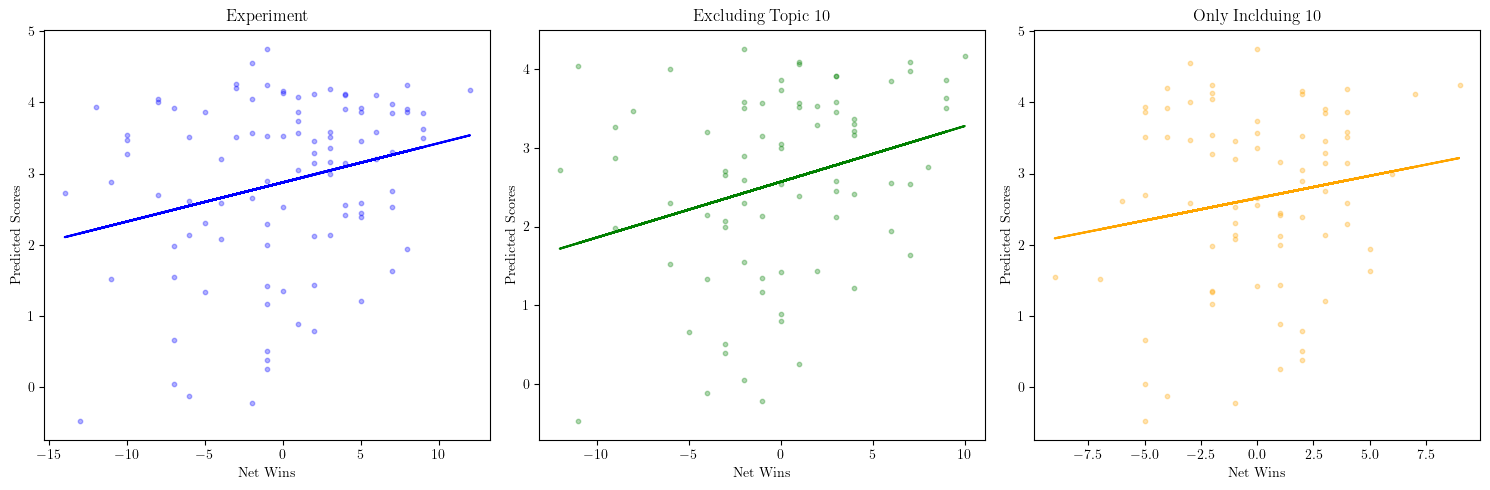

In [193]:
import matplotlib.pyplot as plt
import numpy as np

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for df_experiment
x = df_experiment.Net_Wins
y = df_experiment.pred_response
m, b = np.polyfit(x, y, 1)
axs[0].scatter(x, y, alpha=0.3, s=10, color='blue')  # Change scatter color
axs[0].plot(x, m*x + b, color="blue")
axs[0].set_title("Experiment")
axs[0].set_xlabel("Net Wins")
axs[0].set_ylabel("Predicted Scores")

# Plot for df_experiment_268
x = df_experiment_268.Net_Wins
y = df_experiment_268.pred_response
m, b = np.polyfit(x, y, 1)
axs[1].scatter(x, y, alpha=0.3, s=10, color='green')  # Change scatter color
axs[1].plot(x, m*x + b, color="green")
axs[1].set_title("Excluding Topic 10")
axs[1].set_xlabel("Net Wins")
axs[1].set_ylabel("Predicted Scores")

# Plot for df_experiment_10
x = df_experiment_10.Net_Wins
y = df_experiment_10.pred_response
m, b = np.polyfit(x, y, 1)
axs[2].scatter(x, y, alpha=0.3, s=10, color='orange')  # Change scatter color
axs[2].plot(x, m*x + b, color="orange")
axs[2].set_title("Only Inclduing 10")
axs[2].set_xlabel("Net Wins")
axs[2].set_ylabel("Predicted Scores")

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [35]:
import numpy as np
import statsmodels.api as sm

# Linear regression function
def linear_regression_summary(x, y):
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    results = model.fit()
    return results.summary()

# Perform linear regression for df_experiment
x = df_experiment.Net_Wins
y = df_experiment.pred_response
df_experiment_summary = linear_regression_summary(x, y)
print("Regression results for df_experiment:")
print(df_experiment_summary)

# Perform linear regression for df_experiment_268
x = df_experiment_268.Net_Wins
y = df_experiment_268.pred_response
df_experiment_268_summary = linear_regression_summary(x, y)
print("\nRegression results for df_experiment_268:")
print(df_experiment_268_summary)

# Perform linear regression for df_experiment_10
x = df_experiment_10.Net_Wins
y = df_experiment_10.pred_response
df_experiment_10_summary = linear_regression_summary(x, y)
print("\nRegression results for df_experiment_10:")
print(df_experiment_10_summary)


Regression results for df_experiment:
                            OLS Regression Results                            
Dep. Variable:          pred_response   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     6.860
Date:                Sat, 16 Mar 2024   Prob (F-statistic):             0.0102
Time:                        12:35:08   Log-Likelihood:                -158.43
No. Observations:                 100   AIC:                             320.9
Df Residuals:                      98   BIC:                             326.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

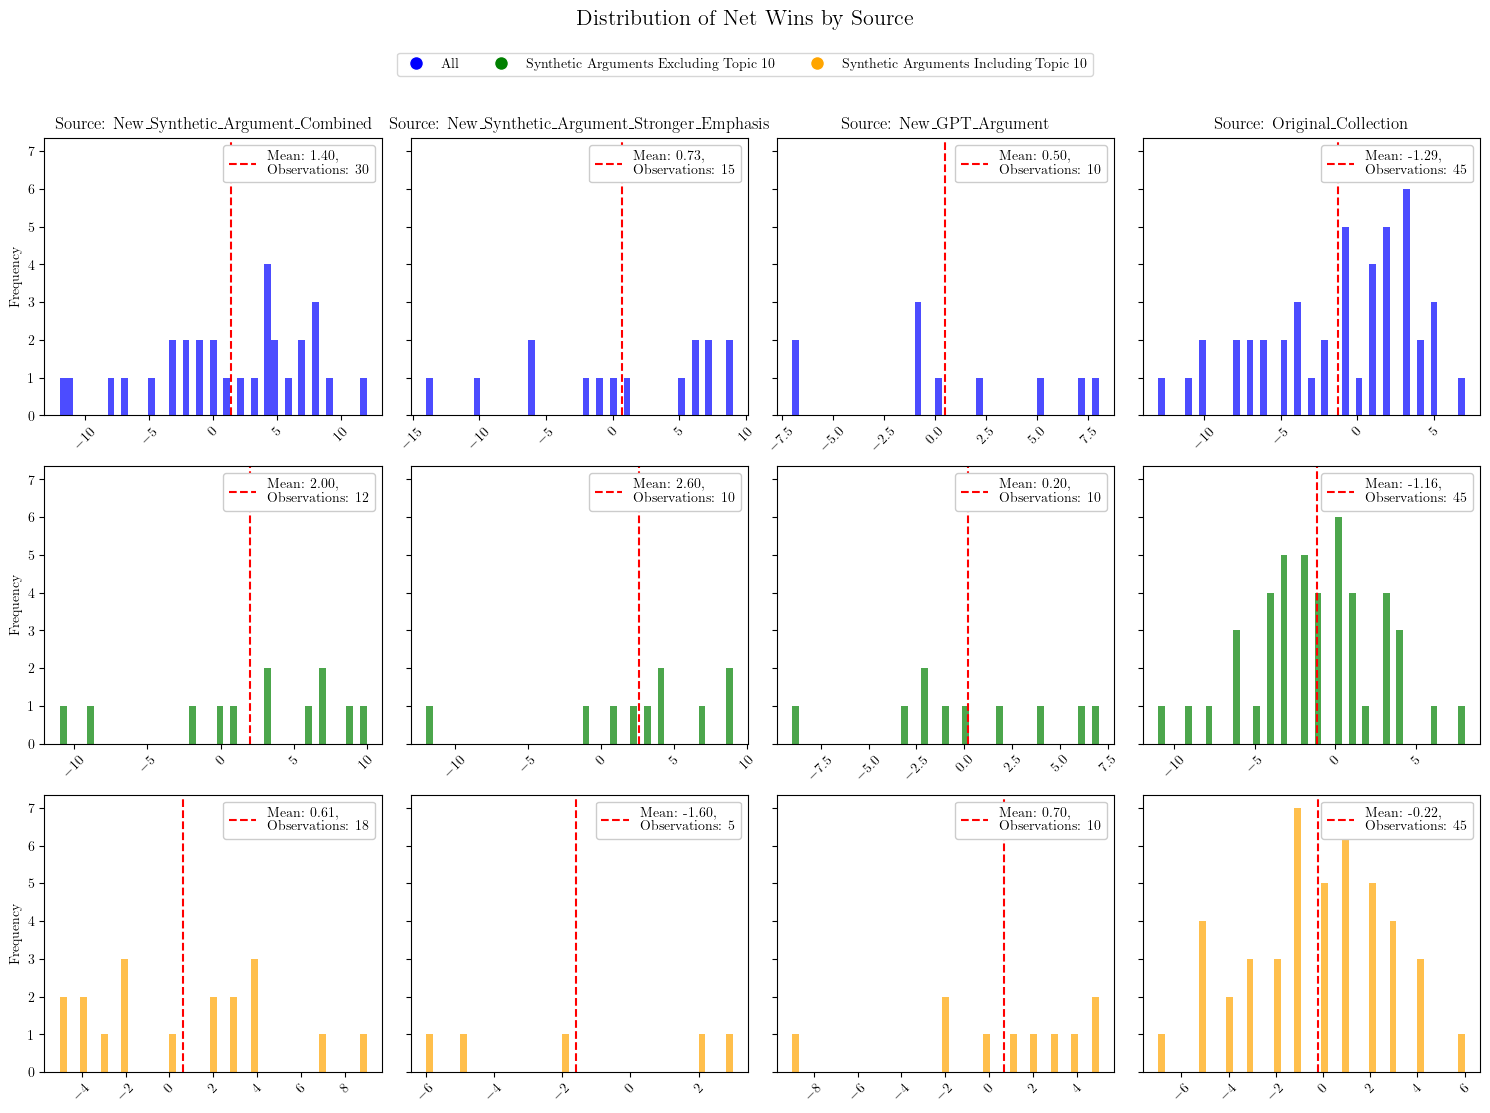

In [36]:
import matplotlib.pyplot as plt

# Assuming df_experiment, df_experiment_268, and df_experiment_10 are your DataFrames
# and Source is one of its columns

unique_sources = df_experiment['Source'].unique()

fig, axes = plt.subplots(3, len(unique_sources), figsize=(15, 12), sharey=True)

# Data for all three experiments
data = [df_experiment, df_experiment_268, df_experiment_10]
colors = ['blue', 'green', 'orange']

for row, df in enumerate(data):
    for i, source in enumerate(unique_sources):
        ax = axes[row, i]
        source_data = df[df['Source'] == source]['Net_Wins']

        # Create histogram using plt.hist()
        counts, bins, _ = ax.hist(source_data, bins=45, color=colors[row], alpha=0.7)  # Set histogram color to blue
        
        # Calculate mean for the current source
        mean = source_data.mean()
        
        # Calculate number of observations
        num_observations = len(source_data)
        
        # Plot vertical line at mean value
        ax.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}, \nObservations: {num_observations}')  # Set line color to red
        ax.legend(loc='upper right').get_frame().set_alpha(1)

        if row == 0:
            ax.set_title(f'Source: {source}')

        # Rotate x-axis labels for better readability
        ax.tick_params(axis='x', rotation=45)

# Set y-label only for the leftmost subplots
for ax in axes[:,0]:
    ax.set_ylabel('Frequency')

# Set the main title for the entire plot
fig.suptitle('Distribution of Net Wins by Source\n', fontsize=16)

legend_colors = ['blue', 'green', 'orange']
legend_labels = ['All', 'Synthetic Arguments Excluding Topic 10', 'Synthetic Arguments Including Topic 10']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color) 
                  for label, color in zip(legend_labels, legend_colors)]

# Adjust the legend position to prevent overlap with the main title
fig.legend(handles=legend_handles, labels=legend_labels, loc='upper center', ncol=len(legend_labels), bbox_to_anchor=(0.5, 0.95))

# Adjust the layout to leave space for the title and legend
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.show()

In [37]:
df_results_table = pd.DataFrame(None, columns = np.sort(df_experiment.Source.unique()), index= np.sort(df_experiment.Source.unique()))
df_results_table = df_results_table.fillna(0)

for tup in tuples_all_experiment:
    df_results_table.loc[df_experiment.Source[tup[1]], df_experiment.Source[tup[0]]] += 1

df_results_table


,New_GPT_Argument,New_Synthetic_Argument_Combined,New_Synthetic_Argument_Stronger_Emphasis,Original_Collection
New_GPT_Argument,10,42,18,54
New_Synthetic_Argument_Combined,37,93,43,160
New_Synthetic_Argument_Stronger_Emphasis,24,54,37,73
Original_Collection,58,186,101,0


In [140]:
df_results_table1 = pd.DataFrame(None, columns = np.sort(df_experiment.Source.unique()), index= np.sort(df_experiment.Source.unique()))
df_results_table2 = pd.DataFrame(None, columns = np.sort(df_experiment.Source.unique()), index= np.sort(df_experiment.Source.unique()))
df_results_table3 = pd.DataFrame(None, columns = np.sort(df_experiment.Source.unique()), index= np.sort(df_experiment.Source.unique()))
df_results_table1 = df_results_table1.fillna(0)
df_results_table2 = df_results_table2.fillna(0)
df_results_table3 = df_results_table2.fillna(0)

for tup in tuples_all_experiment:
    df_results_table1.loc[df_experiment.Source[tup[1]], df_experiment.Source[tup[0]]] += 1

for tup in tuples_experiment_268:
    df_results_table2.loc[df_experiment_268.Source[tup[1]], df_experiment_268.Source[tup[0]]] += 1

for tup in tuples_experiment_10:
    df_results_table3.loc[df_experiment_10.Source[tup[1]], df_experiment_10.Source[tup[0]]] += 1

for i in range(4): 
    df_results_table1.iloc[i,i] = 0
    df_results_table2.iloc[i,i] = 0
    df_results_table3.iloc[i,i] = 0

# get column sums of results table 
# Calculate the three Series
series1 = df_results_table1.sum(axis=0) / (df_results_table1.sum(axis=0) + df_results_table1.sum(axis=1))
series2 = df_results_table2.sum(axis=0) / (df_results_table2.sum(axis=0) + df_results_table2.sum(axis=1))
series3 = df_results_table3.sum(axis=0) / (df_results_table3.sum(axis=0) + df_results_table3.sum(axis=1))

# Column bind the Series
result = pd.concat([series1, series2, series3], axis=1)

# Optionally, you can rename the columns
result.columns = ['All', 'Excluding Topic 10', 'Only Including Topic 10']
print("**Win Rates**")
print(result.to_markdown())


**Win Rates**
|                                          |      All |   Excluding Topic 10 |   Only Including Topic 10 |
|:-----------------------------------------|---------:|---------------------:|--------------------------:|
| New_GPT_Argument                         | 0.51073  |             0.505747 |                  0.520468 |
| New_Synthetic_Argument_Combined          | 0.54023  |             0.556075 |                  0.521401 |
| New_Synthetic_Argument_Stronger_Emphasis | 0.517572 |             0.575581 |                  0.455556 |
| Original_Collection                      | 0.454114 |             0.430851 |                  0.486413 |


In [142]:
win_rates = series1 

In [39]:
#bootstrapped 
import random
def CI_experiment_bootstrap(df_experiment, tuples_all_experiment, n = 10):
    df_results_table = pd.DataFrame(None, columns = np.sort(df_experiment.Source.unique()), index= np.sort(df_experiment.Source.unique()))
    df_results_table = df_results_table.fillna(0)

    bootstrap_diff_means_1= []
    bootstrap_diff_means_2= []
    for _ in range(n):
        bootstrap_sample = random.choices(tuples_all_experiment, k=len(tuples_all_experiment))
        
        for tup in bootstrap_sample:
            df_results_table.loc[df_experiment.Source[tup[1]], df_experiment.Source[tup[0]]] += 1

        for i in range(4): 
            df_results_table.iloc[i,i] = 0

        # get column sums of results table 
        win_rates = df_results_table.sum(axis=0) / (df_results_table.sum(axis=0) + df_results_table.sum(axis=1))
        
        bootstrap_diff_means_1.append(win_rates[0]-win_rates[1])
        bootstrap_diff_means_2.append(win_rates[0]-win_rates[2])

    lower_1 = np.mean(bootstrap_diff_means_1) - 1.96*np.std(bootstrap_diff_means_1-np.mean(bootstrap_diff_means_1))
    upper_1 = np.mean(bootstrap_diff_means_1) + 1.96*np.std(bootstrap_diff_means_1-np.mean(bootstrap_diff_means_1))

    lower_2 = np.mean(bootstrap_diff_means_2) - 1.96*np.std(bootstrap_diff_means_2-np.mean(bootstrap_diff_means_2))
    upper_2 = np.mean(bootstrap_diff_means_2) + 1.96*np.std(bootstrap_diff_means_2-np.mean(bootstrap_diff_means_2))

    print("\n")
    print("Bootstrapped Confidence Interval for the difference in win rates: \nNew_GPT_Argument - New_Synthetic_Argument_Combined:")
    print(f"CI: [{lower_1:.4f},{upper_1:.4f}], Mean difference:{np.mean(bootstrap_diff_means_1):.04f}")
    print("\n")

    print("Bootstrapped Confidence Interval for the difference in win rates: \nNew_GPT_Argument - New_Synthetic_Argument_Combined:")
    print(f"CI: [{lower_2:.4f},{upper_2:.4f}], Mean difference:{np.mean(bootstrap_diff_means_2):.04f}")

In [40]:
print("All Arguments")
CI_experiment_bootstrap(df_experiment, tuples_all_experiment, n =500)
print("---"*20)

print(" \n \nExcluding Topic 10")
CI_experiment_bootstrap(df_experiment_268, tuples_experiment_268, n =500)

print("---"*20)
print(" \n \nOnly Including Topic 10")
CI_experiment_bootstrap(df_experiment_10, tuples_experiment_10, n =500)

All Arguments


KeyboardInterrupt: 

In [120]:
#bootstrapped win rates 
import random
def CI_experiment_bootstrap(df_experiment, tuples_all_experiment, n = 10):
    df_results_table = pd.DataFrame(None, columns = np.sort(df_experiment.Source.unique()), index= np.sort(df_experiment.Source.unique()))
    df_results_table = df_results_table.fillna(0)

    win_rates_bs = np.matrix(np.zeros((n, 4)))
    for k in range(n):
        bootstrap_sample = random.choices(tuples_all_experiment, k=len(tuples_all_experiment))
        
        for tup in bootstrap_sample:
            df_results_table.loc[df_experiment.Source[tup[1]], df_experiment.Source[tup[0]]] += 1

        for i in range(4): 
            df_results_table.iloc[i,i] = 0

        # get column sums of results table 
        win_rates = df_results_table.sum(axis=0) / (df_results_table.sum(axis=0) + df_results_table.sum(axis=1))
        
        win_rates_bs[k,:] = win_rates

    return win_rates_bs

In [200]:
random.seed(2024)

win_rates_bs = CI_experiment_bootstrap(df_experiment, tuples_all_experiment, n =500)

lower = np.mean(win_rates_bs, axis=0) - 1.96*np.std(win_rates_bs-np.mean(win_rates_bs, axis=0), axis=0)
upper = np.mean(win_rates_bs, axis=0) + 1.96*np.std(win_rates_bs-np.mean(win_rates_bs, axis=0), axis=0)

diff1 = win_rates_bs[:,1] - win_rates_bs[:,0] 
diff2 = win_rates_bs[:,1] - win_rates_bs[:,2]
diff3 = win_rates_bs[:,1] - win_rates_bs[:,3]


lower1 = np.mean(diff1) - 1.96*np.std(diff1-np.mean(diff1))
upper1 = np.mean(diff1) + 1.96*np.std(diff1-np.mean(diff1))

lower2 = np.mean(diff2) - 1.96*np.std(diff2-np.mean(diff2))
upper2 = np.mean(diff2) + 1.96*np.std(diff2-np.mean(diff2))

lower3 = np.mean(diff3) - 1.96*np.std(diff3-np.mean(diff3))
upper3 = np.mean(diff3) + 1.96*np.std(diff3-np.mean(diff3))

CIs = pd.DataFrame(np.vstack((lower, upper)), columns = df_experiment.Source.unique(), index = ["Lower", "Upper"])
CIs_list =[f"[{100*CIs.iloc[0,i]:.1f}, {100*CIs.iloc[1,i]:.1f}]" for i in range(4)]

CIs_diff_list = []
CIs_diff_list.append(f"[{100*lower1:.1f}, {100*upper1:.1f}]")
CIs_diff_list.append(f"-")
CIs_diff_list.append(f"[{100*lower2:.1f}, {100*upper2:.1f}]")
CIs_diff_list.append(f"[{100*lower3:.1f}, {100*upper3:.1f}]")

win_rates_list = [w for w in win_rates]
win_rates_list = [w*100 for w in win_rates_list]

win_diff_list = [
    win_rates_list[1] - win_rates_list[0],
    "-",
    win_rates_list[1] - win_rates_list[2],
    win_rates_list[1] - win_rates_list[3]
]




In [204]:
df_CI = pd.DataFrame(None, columns = ["Win Rates (\%)", "95\% CI", "Diff to SY", "Diff 95\% CI"])
df_CI["Win Rates (\%)"] = win_rates_list
df_CI["95\% CI"] = CIs_list
df_CI["Diff to SY"] = win_diff_list
df_CI["Diff 95\% CI"] = CIs_diff_list

# df_CI.index =  ['GPT-best (GPT)', 'Argument Synthesis (AS)', 'Stronger Emphasis (SE)', 'Original (OG)', 'Diff: AS - GPT', 'Diff: AS - SE', 'Diff: AS - OG']

# Reorder rows
df_CI = df_CI.reindex([1, 3, 0, 2])

# Update index labels
df_CI.index = ['Argument Synthesis (SY)', 'Original (OG)', 'GPT-best (GPT)', 'Stronger Emphasis (SE)']

print(df_CI.to_markdown())



print(df_CI.to_latex(float_format="%.1f"))

|                         |   Win Rates (\%) | 95\% CI      | Diff to SY         | Diff 95\% CI   |
|:------------------------|-----------------:|:-------------|:-------------------|:---------------|
| Argument Synthesis (SY) |          54.023  | [53.7, 54.7] | -                  | -              |
| Original (OG)           |          45.4114 | [45.0, 45.5] | 8.61159610068384   | [8.2, 9.6]     |
| GPT-best (GPT)          |          51.073  | [50.4, 51.2] | 2.950027132356574  | [2.5, 4.2]     |
| Stronger Emphasis (SE)  |          51.7572 | [51.7, 52.3] | 2.2658000073445805 | [1.4, 2.9]     |
\begin{tabular}{lrlll}
\toprule
 & Win Rates (\%) & 95\% CI & Diff to SY & Diff 95\% CI \\
\midrule
Argument Synthesis (SY) & 54.0 & [53.7, 54.7] & - & - \\
Original (OG) & 45.4 & [45.0, 45.5] & 8.6 & [8.2, 9.6] \\
GPT-best (GPT) & 51.1 & [50.4, 51.2] & 3.0 & [2.5, 4.2] \\
Stronger Emphasis (SE) & 51.8 & [51.7, 52.3] & 2.3 & [1.4, 2.9] \\
\bottomrule
\end{tabular}



## More heterogeneity analysis 

In [80]:

df_experiment_10 = df_experiment
df_experiment_10 = df_experiment[(df_experiment_10.topic1 == 10) | (df_experiment_10.topic2 == 10) |
                                 ((df_experiment_10.topic2.isna()) & (df_experiment_10.topic1.isna()))]

df_experiment_8 = df_experiment
df_experiment_8 = df_experiment[(df_experiment_8.topic1 == 8) | (df_experiment_8.topic2 == 8) |
                                 ((df_experiment_8.topic2.isna()) & (df_experiment_8.topic1.isna()))]

df_experiment_6 = df_experiment
df_experiment_6 = df_experiment[(df_experiment_6.topic1 == 6) | (df_experiment_6.topic2 == 6) |
                                 ((df_experiment_6.topic2.isna()) & (df_experiment_6.topic1.isna()))]

df_experiment_2 = df_experiment
df_experiment_2 = df_experiment[(df_experiment_2.topic1 == 2) | (df_experiment_2.topic2 == 2) |
                                 ((df_experiment_2.topic2.isna()) & (df_experiment_2.topic1.isna()))]

df_experiment_no10 = df_experiment
df_experiment_no10 = df_experiment_no10[(df_experiment_no10.topic1 != 10) & (df_experiment_no10.topic2 != 10)]

df_experiment_no8 = df_experiment
df_experiment_no8 = df_experiment_no8[(df_experiment_no8.topic1 != 8) & (df_experiment_no8.topic2 != 8)]

df_experiment_no6 = df_experiment
df_experiment_no6 = df_experiment_no6[(df_experiment_no6.topic1 != 6) & (df_experiment_no6.topic2 != 6)]

df_experiment_no2 = df_experiment
df_experiment_no2 = df_experiment_no2[(df_experiment_no2.topic1 != 2) & (df_experiment_no2.topic2 != 2)]


print(f"{df_experiment_268.shape =},{df_experiment_10.shape =}")

df_experiment_268.shape =(77, 50),df_experiment_10.shape =(78, 50)


In [98]:
# count how often each Source value appears 
series1 = df_experiment.Source.value_counts()
series2 = df_experiment_2.Source.value_counts()
series3 = df_experiment_6.Source.value_counts()
series4 = df_experiment_8.Source.value_counts()
series5 = df_experiment_10.Source.value_counts()

series6 = df_experiment_no2.Source.value_counts()
series7 = df_experiment_no6.Source.value_counts()
series8 = df_experiment_no8.Source.value_counts()
series9 = df_experiment_no10.Source.value_counts()

# create a new dataframe from the series
df_source_counts = pd.concat([series1, series2, series3, series4, series5, 
                              series6, series7, series8, series9], axis=1)

# rename the columns
df_source_counts.columns = ["All_Arguments", "Topic 2", "Topic 6", "Topic 8", "Topic 10", "No Topic 2", "No Topic 6", "No Topic 8", "No Topic 10"]
print(df_source_counts.to_markdown())

# df_source_counts.index = ['GPT', 'AS', 'SE', 'OG']
# print(df_source_counts.to_latex())

| Source                                   |   All_Arguments |   Topic 2 |   Topic 6 |   Topic 8 |   Topic 10 |   No Topic 2 |   No Topic 6 |   No Topic 8 |   No Topic 10 |
|:-----------------------------------------|----------------:|----------:|----------:|----------:|-----------:|-------------:|-------------:|-------------:|--------------:|
| Original_Collection                      |              45 |        45 |        45 |        45 |         45 |           45 |           45 |           45 |            45 |
| New_Synthetic_Argument_Combined          |              30 |        17 |         5 |         9 |         18 |           13 |           25 |           21 |            12 |
| New_Synthetic_Argument_Stronger_Emphasis |              15 |         5 |         1 |         4 |          5 |           10 |           14 |           11 |            10 |
| New_GPT_Argument                         |              10 |        10 |        10 |        10 |         10 |           10 |         

In [84]:
tuples_experiment_10 = []
for tup in tuples_all_experiment:
    if (tup[0] in df_experiment_10.index) & (tup[1] in df_experiment_10.index):
        tuples_experiment_10.append(tup)

tuples_experiment_8 = []
for tup in tuples_all_experiment:
    if (tup[0] in df_experiment_8.index) & (tup[1] in df_experiment_8.index):
        tuples_experiment_8.append(tup)

tuples_experiment_6 = []
for tup in tuples_all_experiment:
    if (tup[0] in df_experiment_6.index) & (tup[1] in df_experiment_6.index):
        tuples_experiment_6.append(tup)

tuples_experiment_2 = []
for tup in tuples_all_experiment:
    if (tup[0] in df_experiment_2.index) & (tup[1] in df_experiment_2.index):
        tuples_experiment_2.append(tup)

tuples_experiment_no10 = []
for tup in tuples_all_experiment:
    if (tup[0] in df_experiment_no10.index) & (tup[1] in df_experiment_no10.index):
        tuples_experiment_no10.append(tup)

tuples_experiment_no8 = []
for tup in tuples_all_experiment:
    if (tup[0] in df_experiment_no8.index) & (tup[1] in df_experiment_no8.index):
        tuples_experiment_no8.append(tup)

tuples_experiment_no6 = []
for tup in tuples_all_experiment:
    if (tup[0] in df_experiment_no6.index) & (tup[1] in df_experiment_no6.index):
        tuples_experiment_no6.append(tup)

tuples_experiment_no2 = []
for tup in tuples_all_experiment:
    if (tup[0] in df_experiment_no2.index) & (tup[1] in df_experiment_no2.index):
        tuples_experiment_no2.append(tup)

df_experiment_10["Net_Wins"] = create_dataframe_net_wins(tuples_experiment_10, n = df_experiment.shape[0]).Net_Wins[df_experiment_10.index]
df_experiment_8["Net_Wins"] = create_dataframe_net_wins(tuples_experiment_8, n = df_experiment.shape[0]).Net_Wins[df_experiment_8.index]
df_experiment_6["Net_Wins"] = create_dataframe_net_wins(tuples_experiment_6, n = df_experiment.shape[0]).Net_Wins[df_experiment_6.index]
df_experiment_2["Net_Wins"] = create_dataframe_net_wins(tuples_experiment_2, n = df_experiment.shape[0]).Net_Wins[df_experiment_2.index]

df_experiment_no10["Net_Wins"] = create_dataframe_net_wins(tuples_experiment_no10, n = df_experiment.shape[0]).Net_Wins[df_experiment_no10.index]
df_experiment_no8["Net_Wins"] = create_dataframe_net_wins(tuples_experiment_no8, n = df_experiment.shape[0]).Net_Wins[df_experiment_no8.index]
df_experiment_no6["Net_Wins"] = create_dataframe_net_wins(tuples_experiment_no6, n = df_experiment.shape[0]).Net_Wins[df_experiment_no6.index]
df_experiment_no2["Net_Wins"] = create_dataframe_net_wins(tuples_experiment_no2, n = df_experiment.shape[0]).Net_Wins[df_experiment_no2.index]

/var/folders/1n/l1qs9bwj2h9c06x52w17rfdm0000gp/T/ipykernel_23531/3286693095.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_experiment_10["Net_Wins"] = create_dataframe_net_wins(tuples_experiment_10, n = df_experiment.shape[0]).Net_Wins[df_experiment_10.index]
/var/folders/1n/l1qs9bwj2h9c06x52w17rfdm0000gp/T/ipykernel_23531/3286693095.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_experiment_8["Net_Wins"] = create_dataframe_net_wins(tuples_experiment_8, n = df_experiment.shape[0]).Net_Wins[

In [116]:
df_results_table = pd.DataFrame(None, columns = np.sort(df_experiment.Source.unique()), index= np.sort(df_experiment.Source.unique()))
df_results_table10 = pd.DataFrame(None, columns = np.sort(df_experiment.Source.unique()), index= np.sort(df_experiment.Source.unique()))
df_results_table8 = pd.DataFrame(None, columns = np.sort(df_experiment.Source.unique()), index= np.sort(df_experiment.Source.unique()))
df_results_table6 = pd.DataFrame(None, columns = np.sort(df_experiment.Source.unique()), index= np.sort(df_experiment.Source.unique()))
df_results_table2 = pd.DataFrame(None, columns = np.sort(df_experiment.Source.unique()), index= np.sort(df_experiment.Source.unique()))
df_results_table_no10 = pd.DataFrame(None, columns = np.sort(df_experiment.Source.unique()), index= np.sort(df_experiment.Source.unique()))
df_results_table_no8 = pd.DataFrame(None, columns = np.sort(df_experiment.Source.unique()), index= np.sort(df_experiment.Source.unique()))
df_results_table_no6 = pd.DataFrame(None, columns = np.sort(df_experiment.Source.unique()), index= np.sort(df_experiment.Source.unique()))
df_results_table_no2 = pd.DataFrame(None, columns = np.sort(df_experiment.Source.unique()), index= np.sort(df_experiment.Source.unique()))

df_results_table = df_results_table.fillna(0)
df_results_table10 = df_results_table10.fillna(0)
df_results_table8 = df_results_table8.fillna(0)
df_results_table6 = df_results_table6.fillna(0)
df_results_table2 = df_results_table2.fillna(0)
df_results_table_no10 = df_results_table_no10.fillna(0)
df_results_table_no8 = df_results_table_no8.fillna(0)
df_results_table_no6 = df_results_table_no6.fillna(0)
df_results_table_no2 = df_results_table_no2.fillna(0)

for tup in tuples_all_experiment:
    df_results_table.loc[df_experiment.Source[tup[1]], df_experiment.Source[tup[0]]] += 1

for tup in tuples_experiment_10:
    df_results_table10.loc[df_experiment_10.Source[tup[1]], df_experiment_10.Source[tup[0]]] += 1

for tup in tuples_experiment_8:
    df_results_table8.loc[df_experiment_8.Source[tup[1]], df_experiment_8.Source[tup[0]]] += 1

for tup in tuples_experiment_6:
    df_results_table6.loc[df_experiment_6.Source[tup[1]], df_experiment_6.Source[tup[0]]] += 1

for tup in tuples_experiment_2:
    df_results_table2.loc[df_experiment_2.Source[tup[1]], df_experiment_2.Source[tup[0]]] += 1

for tup in tuples_experiment_no10:
    df_results_table_no10.loc[df_experiment_no10.Source[tup[1]], df_experiment_no10.Source[tup[0]]] += 1

for tup in tuples_experiment_no8:
    df_results_table_no8.loc[df_experiment_no8.Source[tup[1]], df_experiment_no8.Source[tup[0]]] += 1

for tup in tuples_experiment_no6:
    df_results_table_no6.loc[df_experiment_no6.Source[tup[1]], df_experiment_no6.Source[tup[0]]] += 1

for tup in tuples_experiment_no2:
    df_results_table_no2.loc[df_experiment_no2.Source[tup[1]], df_experiment_no2.Source[tup[0]]] += 1

for i in range(4):
    df_results_table.iloc[i,i] = 0
    df_results_table10.iloc[i,i] = 0
    df_results_table8.iloc[i,i] = 0
    df_results_table6.iloc[i,i] = 0
    df_results_table2.iloc[i,i] = 0
    df_results_table_no10.iloc[i,i] = 0
    df_results_table_no8.iloc[i,i] = 0
    df_results_table_no6.iloc[i,i] = 0
    df_results_table_no2.iloc[i,i] = 0

# Calculate the 8 Series
series0 = df_results_table.sum(axis=0) / (df_results_table.sum(axis=0) + df_results_table.sum(axis=1))
series1 = df_results_table10.sum(axis=0) / (df_results_table10.sum(axis=0) + df_results_table10.sum(axis=1))
series2 = df_results_table8.sum(axis=0) / (df_results_table8.sum(axis=0) + df_results_table8.sum(axis=1))
series3 = df_results_table6.sum(axis=0) / (df_results_table6.sum(axis=0) + df_results_table6.sum(axis=1))
series4 = df_results_table2.sum(axis=0) / (df_results_table2.sum(axis=0) + df_results_table2.sum(axis=1))

series5 = df_results_table_no10.sum(axis=0) / (df_results_table_no10.sum(axis=0) + df_results_table_no10.sum(axis=1))
series6 = df_results_table_no8.sum(axis=0) / (df_results_table_no8.sum(axis=0) + df_results_table_no8.sum(axis=1))
series7 = df_results_table_no6.sum(axis=0) / (df_results_table_no6.sum(axis=0) + df_results_table_no6.sum(axis=1))
series8 = df_results_table_no2.sum(axis=0) / (df_results_table_no2.sum(axis=0) + df_results_table_no2.sum(axis=1))

# Column bind the Series
result = pd.concat([series0, 
                    series4, series3, series2, series1, 
                    series8, series7, series6, series5], 
                    axis=1)
result.columns = ['All', 'Topic (2)', 'Topic (6)', 'Topic (8)', 'Topic (10)', 
                  'No Topic (2)', 'No Topic (6)', 'No Topic (8)', 'No Topic (10)']
result = result * 100

print("**Win Rates in percent**")
print(result.to_markdown())

result.index = ['GPT', 'AS', 'SE', 'OG']
print(result.to_latex(float_format="%.1f"))

**Win Rates in percent**
|                                          |     All |   Topic (2) |   Topic (6) |   Topic (8) |   Topic (10) |   No Topic (2) |   No Topic (6) |   No Topic (8) |   No Topic (10) |
|:-----------------------------------------|--------:|------------:|------------:|------------:|-------------:|---------------:|---------------:|---------------:|----------------:|
| New_GPT_Argument                         | 51.073  |     51.4793 |     54.6154 |     49.3056 |      52.0468 |        51.1364 |        49.3023 |        52.7363 |         50.5747 |
| New_Synthetic_Argument_Combined          | 54.023  |     55.8935 |     50.6494 |     52.0833 |      52.1401 |        52.8302 |        54.0793 |        54.9419 |         55.6075 |
| New_Synthetic_Argument_Stronger_Emphasis | 51.7572 |     54.1176 |     31.25   |     61.5385 |      45.5556 |        50.8287 |        54.0925 |        48.7562 |         57.5581 |
| Original_Collection                      | 45.4114 |     43.9093 |  

Index(['New_GPT_Argument', 'New_Synthetic_Argument_Combined',
       'New_Synthetic_Argument_Stronger_Emphasis', 'Original_Collection'],
      dtype='object')

### Check for pairs of original argument vs edited arguments 

In [43]:
# # fix index to match previous argument collection
df_experiment["Argument_ID"] = df_experiment.index + 1309
for i in range(55,df_experiment.shape[0]): 
    df_experiment["Argument_ID"][i] = np.where(df_experiment["synth_text"][i] == df.New_Argument)[0][0]

tuples_all_experiment_corrected = [] 
for tup in tuples_all_experiment:
    tuples_all_experiment_corrected.append((df_experiment["Argument_ID"][tup[0]], df_experiment["Argument_ID"][tup[1]])) 


/var/folders/1n/l1qs9bwj2h9c06x52w17rfdm0000gp/T/ipykernel_23531/2762802042.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_experiment["Argument_ID"][i] = np.where(df_experiment["synth_text"][i] == df.New_Argument)[0][0]
/var/folders/1n/l1qs9bwj2h9c06x52w17rfdm0000gp/T/ipykernel_23531/2762802042.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_experiment["Argument_ID"][i] = np.where(df_experiment["synth_text"][i] == df.New_Argument)[0][0]
/var/folders/1n/l1qs9bwj2h9c06x52w17rfdm0000gp/T/ipykernel_23531/2762802042.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [44]:
tuples_experiment_old_vs_new = []
for tup in tuples_all_experiment_corrected:
    arg_idx = np.where(df_experiment.Argument_ID == np.max(tup))[0][0]
    if (np.min(tup) == df_experiment.arg1[arg_idx]) | (np.min(tup) == df_experiment.arg2[arg_idx]): 
        tuples_experiment_old_vs_new.append(tup)

In [111]:
df_results_table = pd.DataFrame(None, columns = np.sort(df_experiment.Source.unique()), index= np.sort(df_experiment.Source.unique()))
df_results_table = df_results_table.fillna(0)

for tup in tuples_experiment_old_vs_new:
    df_results_table.loc[df_experiment.Source[tup[1]==df_experiment.Argument_ID], df_experiment.Source[tup[0]==df_experiment.Argument_ID]] += 1

df_results_table

df_results_table.columns = ['GPT', 'AS', 'SE', 'OG']
df_results_table.index = ['GPT-best (GPT)', ' AS', 'SE', 'OG']
print(df_results_table.to_latex(float_format="%.0f"))

\begin{tabular}{lrrrr}
\toprule
 & GPT & AS & SE & OG \\
\midrule
GPT-best (GPT) & 0 & 0 & 0 & 0 \\
 AS & 0 & 0 & 0 & 5 \\
SE & 0 & 0 & 0 & 1 \\
OG & 0 & 7 & 0 & 0 \\
\bottomrule
\end{tabular}



## BT Score inference


In [226]:
# # # fix index to match previous argument collection
# df_experiment["Argument_ID"] = df_experiment.index + 1309
# for i in range(55,df_experiment.shape[0]): 
#     df_experiment["Argument_ID"][i] = np.where(df_experiment["synth_text"][i] == df.New_Argument)[0][0]

# tuples_all_experiment_corrected = [] 
# for tup in tuples_all_experiment:
#     tuples_all_experiment_corrected.append((df_experiment["Argument_ID"][tup[0]], df_experiment["Argument_ID"][tup[1]])) 


In [739]:
df_W_train = create_dataframe_BT(tuples_train)
bt_scores_train = BT_fitting(df_W_train + 0.01, max_iter=100)

df_W_all_original = create_dataframe_BT_full(tuples_all, n_col = df.shape[0])
bt_scores_all_original = BT_fitting(df_W_all_original + 0.01, max_iter=100)

initial_scores = np.ones(df.shape[0])
initial_scores[df_W_train.index] = bt_scores_train
bt_scores_inferred_original = BT_fitting(df_W_all_original + 0.01, initial_scores=initial_scores,fixed_scores=list(df_W_train.index), max_iter=100)
# bt_scores_all_inferred[df_W_train.index] = bt_scores_train

converged
converged
converged


In [740]:
# df_W_train = create_dataframe_BT(tuples_train)
# bt_scores_train = BT_fitting(df_W_train + 0.01, max_iter=100)

df_W_all = create_dataframe_BT_full(tuples_all + tuples_all_experiment_corrected, n_col = df.shape[0]+55)
bt_scores_all = BT_fitting(df_W_all + 0.01, max_iter=100)

# Only fix training scores
# initial_scores = np.ones(df.shape[0]+55)
# initial_scores[df_W_train.index] = bt_scores_train
# bt_scores_all_inferred = BT_fitting(df_W_all + 0.01, initial_scores=initial_scores,fixed_scores=list(df_W_train.index), max_iter=1000)

# fix training and previous test set scores
initial_scores = np.ones(df.shape[0] + 55)
initial_scores[df_W_all_original.index] = bt_scores_inferred_original
bt_scores_all_inferred = BT_fitting(df_W_all + 0.01, initial_scores=initial_scores,fixed_scores=list(df_W_all_original.index), max_iter=1000)


converged
converged


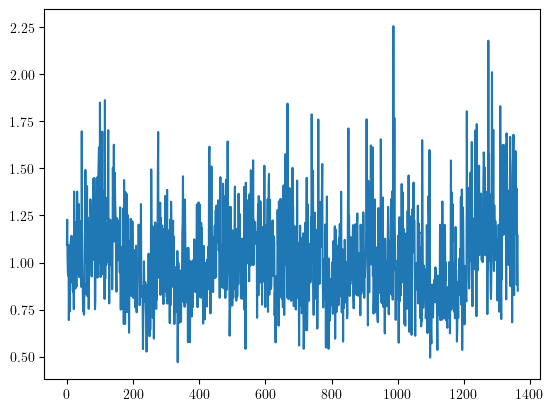

In [741]:
plt.plot(bt_scores_all_inferred)

In [742]:
df_experiment["BT_Score"] = None
for i in range(df_experiment.shape[0]): 
    df_experiment["BT_Score"][i] = bt_scores_all_inferred[df_experiment["Argument_ID"][i]]
    # df_experiment["BT_Score"][i] = bt_scores_all[df_experiment["Argument_ID"][i]]

In [743]:
df_experiment.groupby("Source").BT_Score.mean()

Source
New_GPT_Argument                            1.215048
New_Synthetic_Argument_Combined             1.279146
New_Synthetic_Argument_Stronger_Emphasis    1.249289
Original_Collection                         1.676736
Name: BT_Score, dtype: object

In [744]:
print(f"BT Score for combined synth args: {bt_scores_all[-55:-20].mean()} \n\
BT Score for stronger emphasis synth args: {bt_scores_all[-20:].mean() } \n\
BT Score for GPT best args: {bt_scores_all[-10:].mean()}")

BT Score for combined synth args: 1.1887248222838358 
BT Score for stronger emphasis synth args: 1.1522372004442663 
BT Score for GPT best args: 1.1419186886999557


### Fit BT Score on new observations only

In [181]:
df_W_experiment= create_dataframe_BT_full(tuples_all_experiment, n_col = df_experiment.shape[0])
bt_scores_all_experiment = BT_fitting(df_W_experiment + 0.01, max_iter=100)

converged


In [182]:
df_experiment["BT_Score"] = bt_scores_all_experiment
df_experiment.groupby("Source").BT_Score.mean()

Source
New_GPT_Argument                            1.174093
New_Synthetic_Argument_Combined             1.280423
New_Synthetic_Argument_Stronger_Emphasis    1.187142
Original_Collection                         1.100212
Name: BT_Score, dtype: float64

In [566]:
#bootstrapped 
import random

bootstrap_diff_means= []
for _ in range(50):
    bootstrap_sample = random.choices(tuples_all_experiment, k=len(tuples_all_experiment))
    
    df_W_bootstrap= create_dataframe_BT_full(bootstrap_sample, n_col = df_experiment.shape[0])
    bt_scores_bootstrap = BT_fitting(df_W_bootstrap + 0.0001, max_iter=100)

    df_experiment["BS_BT_Score"] = bt_scores_bootstrap 
    
    bootstrap_diff_means.append(df_experiment.groupby("Source").BS_BT_Score.mean()[0]-df_experiment.groupby("Source").BS_BT_Score.mean()[1])

lower = np.mean(bootstrap_diff_means) - 1.96*np.std(bootstrap_diff_means-np.mean(bootstrap_diff_means))
upper = np.mean(bootstrap_diff_means) + 1.96*np.std(bootstrap_diff_means-np.mean(bootstrap_diff_means))

print(f"Lower: {lower:.4f}, Mean difference:{np.mean(bootstrap_diff_means):.04f} Upper: {upper:.4f}")

converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
Lower: -2058.5843, Mean difference:132.7401 Upper: 2324.0646


In [568]:
print(f"Lower: {lower:.4f}, Mean difference:{np.mean(bootstrap_diff_means):.04f} Upper: {upper:.4f}")

Lower: -2058.5843, Mean difference:132.7401 Upper: 2324.0646


In [570]:
df_experiment.groupby("Source").BS_BT_Score.mean()

Source
New_GPT_Argument                             2.233502
New_Synthetic_Argument_Combined              2.415453
New_Synthetic_Argument_Stronger_Emphasis     1.677218
Original_Collection                         55.400263
Name: BS_BT_Score, dtype: float64

In [575]:
np.mean(bootstrap_diff_means)

132.74014567636445

# check MTurk results

In [86]:
import pandas as pd

# List of CSV files
csv_files = [
    "Batch_5184802_batch_results.csv",
    "Batch_5183970_batch_results.csv",
    "Batch_5183971_batch_results.csv",
    "Batch_5184039_batch_results.csv",
    "Batch_5184344_batch_results.csv",
    "Batch_5184346_batch_results.csv",
    "Batch_5184347_batch_results.csv",
    "Batch_5184348_batch_results.csv",
    "Batch_5184646_batch_results.csv",
    "Batch_5183284_batch_results.csv"
]

# Read each CSV file into a DataFrame and store in a list
data_frames = [pd.read_csv(str(data_dir) + "/Survey/" + file) for file in csv_files]

# Stack the DataFrames vertically
stacked_data = pd.concat(data_frames, axis=0)

# Count the number of unique elements in the first column
unique_count = stacked_data.iloc[:, 0].nunique()

# Print the result
print(f"Number of unique elements in the first column: {unique_count}")

unique_count = stacked_data.WorkerId.value_counts()


Number of unique elements in the first column: 10


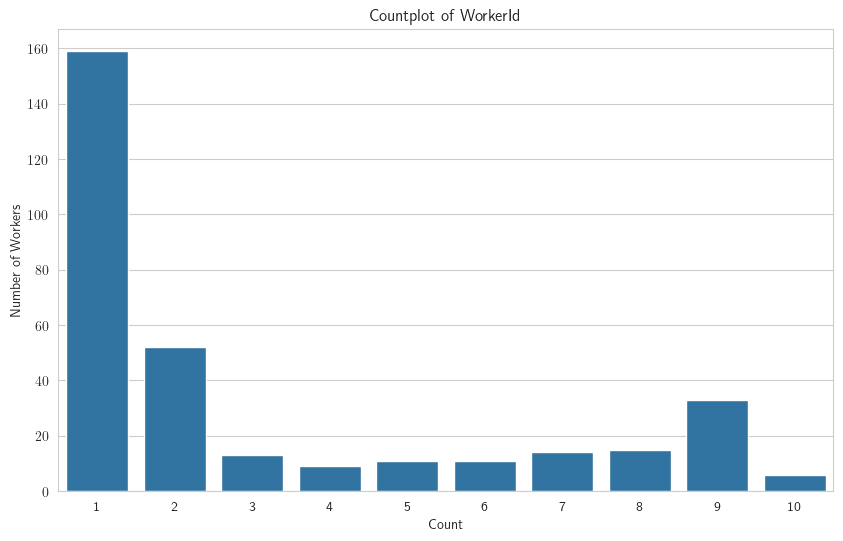

In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of CSV files
csv_files = [
    "Batch_5184802_batch_results.csv",
    "Batch_5183970_batch_results.csv",
    "Batch_5183971_batch_results.csv",
    "Batch_5184039_batch_results.csv",
    "Batch_5184344_batch_results.csv",
    "Batch_5184346_batch_results.csv",
    "Batch_5184347_batch_results.csv",
    "Batch_5184348_batch_results.csv",
    "Batch_5184646_batch_results.csv",
    "Batch_5183284_batch_results.csv"
]

# Read each CSV file into a DataFrame and store in a list
data_frames = [pd.read_csv(str(data_dir) + "/Survey/" + file) for file in csv_files]

# Stack the DataFrames vertically
stacked_data = pd.concat(data_frames, axis=0)

# Count the occurrences of each unique element in the first column
unique_count = stacked_data['WorkerId'].value_counts()

# Create a countplot using seaborn
plt.figure(figsize=(10, 6))
sns.countplot(x=unique_count)
plt.title('Countplot of WorkerId')
plt.xlabel('Count')
plt.ylabel('Number of Workers')
plt.show()


In [115]:
nums = [1,2,3,4,5]
i = 1
for j in nums[0:3]: 
    i = i*j
i

6